In [2]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
import pickle
import torch
import astropy.units as u
import seaborn as sns

from typing import Tuple, Optional, Union
from itertools import cycle
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from sklearn.model_selection import train_test_split
from neural_net import normalize_arr, get_model, CustomLoss, resume
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
from sklearn.impute import KNNImputer
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler

from preprocessing.preprocessing import ab_mag_to_flux

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

# Get Data

In [3]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_cat.pkl', 'rb') as f:
    final_cat = pickle.load(f)

with open(f'/Users/adamboesky/Research/ay98/clean_data/all_photometry.pkl', 'rb') as f:
    final_photo = pickle.load(f)

In [3]:
# functions used for getting the coords given an id
def get_coords_for_id(gal_id: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)
    return coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][1], coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][2]


def get_coords_for_ids(gal_ids: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)

    sorted_inds = np.argsort(coord_lookup_table['gal_id'])
    lup_tab_sorted = coord_lookup_table[sorted_inds]
    print('Sorted')
    
    # Find the sorted indices of 'a' in 'b'
    indices_in_b_sorted = np.searchsorted(lup_tab_sorted['gal_id'], gal_ids, side='left')
    print('Search complete')
    
    # Make sure that all elements of 'a' are actually present in 'b'
    indices_in_b_sorted = indices_in_b_sorted[indices_in_b_sorted < len(coord_lookup_table['gal_id'])]
    valid_mask = lup_tab_sorted['gal_id'][indices_in_b_sorted] == gal_ids
    indices_in_b_sorted = indices_in_b_sorted[valid_mask]
    print('Validation complete')

    # Take the sorted indices and map back to original indices in 'b'
    all_indices = lup_tab_sorted[indices_in_b_sorted]
    
    return all_indices

# Get sne type and host props

## Zou

In [5]:
# Find the host coordinates of all the sne without host coordinates already
sne_names = sne['name'].to_numpy()                  # array of sne names
host_coords = sne[['hostra', 'hostdec']]            # host coordst array
sne_coords = sne[['ra', 'dec']]                     # sne coords array

# Convert everything to np arrays
sne_coords = sne_coords.to_numpy()
host_coords = host_coords.to_numpy()

# Get list of sky coordinates objects for sne with no host and complete sne coords
sne_ra = []
sne_dec = []
for ra, dec in sne_coords:
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')

    sne_ra.append(ra_ang.wrap_at("24h").deg)
    sne_dec.append(dec_ang.deg)

# Add coords to the df
sn_sky_coords = SkyCoord(sne_ra * u.deg, sne_dec * u.deg, frame='icrs')
sne['sky_coord'] = sn_sky_coords

In [6]:
# The centers of the three deep fields
wcdfs_center = SkyCoord(Angle('03:32:09', unit='hourangle').deg * u.deg, Angle('-28:08:32 degrees').deg * u.deg, frame='icrs')
es1_center = SkyCoord(Angle('00:37:47', unit='hourangle').deg * u.deg, Angle('-44:00:07 degrees').deg * u.deg, frame='icrs')
xmmlss_center = SkyCoord(Angle('02:22:10', unit='hourangle').deg * u.deg, Angle('-04:45:00 degrees').deg * u.deg, frame='icrs')

# Get the seperation of each SN from the center of the field
field_seps = np.zeros((len(sn_sky_coords), 3))
for i, field_center in enumerate((wcdfs_center, es1_center, xmmlss_center)):
    field_seps[:, i] = field_center.separation(sn_sky_coords).degree
min_sep = np.min(field_seps, axis=1)
print(min_sep)
print(np.min(min_sep))

[106.4619733  106.15641833 106.46747375 ...   7.32107933  43.03772154
 126.48246176]
0.07885258304887915


In [7]:
max_field_raidus = 4  # 1.3 is the approximate radius of the depe field, but we'll use 4 to be conservative
in_field_mask = min_sep < max_field_raidus
classified_mask = sne[in_field_mask]['claimedtype'] != 'Candidate'
nan_mask = sne[in_field_mask][classified_mask]['claimedtype'].to_numpy().astype(str) == 'nan'
print(f'There are {np.sum(in_field_mask)} supernovae within the deep fields.')
print(f"Of those, approximate {len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are classified.")
print(f"Of the classified, {sne['claimedtype'][in_field_mask][classified_mask].str.contains('ia', case=False, na=False).sum() / len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are type Ia")
classified_field_sne = sne[in_field_mask][classified_mask][~nan_mask]

There are 965 supernovae within the deep fields.
Of those, approximate 586 are classified.
Of the classified, 0.7491467576791809 are type Ia


In [9]:
gal_coords_arr = get_coords_for_ids(final_photo['gal_id'], lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')
gal_coords = SkyCoord(gal_coords_arr['RA'] * u.deg, gal_coords_arr['DEC'] * u.deg, frame='icrs')
smallest_seps = np.array([None for _ in range(len(classified_field_sne))])
hosts_30 = np.array([None for _ in range(len(classified_field_sne))])
hosts_60 = np.array([None for _ in range(len(classified_field_sne))])

# For each supernova, find the host galaxy
for i, coord in enumerate(concatenate(classified_field_sne['sky_coord'])):
    gal_seps = coord.separation(gal_coords).arcsec
    smallest_sep = np.min(gal_seps)
    smallest_sep_ind = np.argmin(gal_seps)
    if smallest_sep < 30:  # Host if the host is less than a 30 arcsec separation
        hosts_30[i] = final_cat['gal_id'][smallest_sep_ind]
        smallest_seps[i] = smallest_sep
    if smallest_sep < 60:  # Host if the host is less than a 30 arcsec separation
        hosts_60[i] = final_cat['gal_id'][smallest_sep_ind]

Sorted
Search complete
Validation complete


In [10]:
# Append host info
classified_field_sne['host'] = hosts_30
classified_field_sne['host_angular_sep_arcsec'] = smallest_seps
classified_field_sne[['event', 'catalog', 'claimedtype', 'host', 'host_angular_sep_arcsec']].head(-10)

# Make nice dictionary of galaxies, sne, and type
type_id_dist = classified_field_sne[['claimedtype', 'host', 'host_angular_sep_arcsec']].dropna().to_numpy()
gal_sne_types = {}
for sne_type, gal_tid, dist in type_id_dist:
    if gal_sne_types.get(gal_tid):
        gal_sne_types[gal_tid].append((sne_type, dist))
    else:
        gal_sne_types[gal_tid] = [(sne_type, dist)]

In [11]:
# Load and preprocess the data for the NN
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat = all_cat['data']
print(f'Fixing the error for {np.sum(all_cat["data_err"][:, 2] == 0.01)} objects')
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error
cat_err = all_cat['data_err']

print('Importing photometry data')

# Filter out z>1
z_local_mask = cat[:, 2] <= 1
photo = photo[z_local_mask]
photo_err = photo_err[z_local_mask]
cat = cat[z_local_mask]
cat_err = cat_err[z_local_mask]


######################## PRE PROCESSING ########################
# Filter out nans
nan_mask = np.isnan(cat).any(axis=1)
photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
print('HEEERRRREE', cat_norm)
print(cat_mean)
print(f'Photo stats:\n \tmean = {photo_mean}\n \tstd = {photo_std}')
print(f'Catalog stats:\n \tmean = {cat_mean}\n \tstd = {cat_std}')
print(f'Length = {len(photo)}')

Fixing the error for 96514 objects
Importing photometry data
HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[ 8.69840122 -0.65829206  0.56184221]
Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
Catalog stats:
 	mean = [ 8.69840122 -0.65829206  0.56184221]
 	std = [1.31209275 1.35189867 0.29137484]
Length = 1261630


In [12]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
model.eval()


# Predict attributes for the galaxies that have SNe
has_sne_mask = np.isin(all_photo['gal_id'][z_local_mask], list(gal_sne_types.keys()))
photo_norm_sne, photo_err_norm_sne = photo_norm[has_sne_mask], photo_err_norm[has_sne_mask]
cat_norm_sne, cat_err_norm_sne = cat_norm[has_sne_mask], cat_err_norm[has_sne_mask]
model.eval()
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_norm_sne))
gal_props_pred_untrans = gal_props_pred.detach().numpy()

In [13]:
final_cat.keys(), final_cat['data']

(dict_keys(['data', 'data_err', 'keys', 'err_keys', 'tractor_id', 'gal_id']),
 array([[ 9.62903439,  1.03851593,  0.628     ],
        [ 8.2620419 ,  0.25606308,  0.817     ],
        [ 8.33771126,  0.3797534 ,  0.729     ],
        ...,
        [ 9.84605304,  1.47017106,  4.321     ],
        [ 8.27052041, -1.06331759,  0.321     ],
        [10.67830631, -0.20828912,  1.9       ]]))

In [14]:
ascii.read('/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts.ecsv', format='ecsv')

objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec
str18,str12,str12,str1,str7,str7,str7,str7,str7,str8,str8,str8,str8,str8,str10,float64,float64
107721619205892726,161.92064364,-0.23139161,1,22.0668,21.425,20.407,20.0965,20.1203,0.0961,0.101155,0.051494,0.043988,0.122115,0.0,161.92058333333333,-0.23130555555555557
107712058701603113,205.87023383,-0.23935961,1,22.5147,20.9821,20.9743,20.3913,20.2973,0.091763,0.074575,0.05595,0.049043,0.082456,0.01495833,205.87024999999997,-0.23947222222222223
107632063598837037,206.35988994,-0.30289261,1,20.0823,19.5422,19.0951,18.9862,19.0652,0.019853,0.02099,0.019187,0.022971,0.044885,0.00145833,206.3599583333333,-0.30294444444444446
108082062811722707,206.28113041,0.06858074,1,20.4369,19.5517,19.1605,18.7795,18.885,0.031441,0.021713,0.021385,0.01781,0.060082,0.0,206.28124999999997,0.06858333333333333
147920354998995147,35.49988855,33.2704423,1,nan,nan,nan,13.2301,nan,nan,nan,nan,0.000708,nan,0.3365476,35.499916666666664,33.270472222222224
154362201644320273,220.16438072,38.63310504,1,19.3579,17.0262,17.5039,17.6189,nan,0.012528,0.003898,0.004463,0.008622,nan,0.1851964,220.16457499999996,38.632930555555554
78403386241262777,338.62412386,-24.66461784,1,14.6607,13.9367,13.5433,13.3523,13.3793,0.000916,0.000576,0.000492,0.000781,0.001559,0.1346905,338.6242083333333,-24.664555555555555
88680959370393358,95.93704409,-16.09752001,1,nan,nan,19.2281,nan,nan,nan,nan,0.010247,nan,nan,0.1107202,95.93695833333334,-16.0975
155182501167214794,250.11673555,39.32014102,1,14.323,13.5509,13.1936,12.9685,13.7157,0.000613,0.000412,0.000293,0.000488,0.000739,0.1284286,250.11674999999997,39.32022222222223


In [15]:
# Filter the values that only appear once
tids, counts = np.unique(final_photo['gal_id'], return_counts=True)
unique_tids = tids[counts == 1]
too_many_tids = tids[counts > 1]

# Get the attributes of the hosts for all the SNe
host_inds = []
sne_props = []
n_not_found = 0
n_multiple_tids = 0
for sn in type_id_dist:
    idx = np.where(final_photo['gal_id'][z_local_mask][has_sne_mask] == sn[1])[0]
    if len(idx) == 1 and sn[1] in unique_tids:  # drop them if the 
        sne_props.append(sn)
        host_inds.append(idx[0])
    elif sn[1] in too_many_tids:
        n_multiple_tids += 1
    elif len(idx) == 0:
        n_not_found += 1

sne_props = np.hstack((sne_props, gal_props_pred_untrans[host_inds]))
sne_props_true = np.hstack((sne_props, cat_norm[has_sne_mask][host_inds]))
print(f'Filtering for z<1 dropped us from {len(type_id_dist)} to {len(sne_props)}. {n_not_found} were dropped because they are z>1 and {n_multiple_tids} dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!')
print(f'SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)')

Filtering for z<1 dropped us from 324 to 289. 35 were dropped because they are z>1 and 0 dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!
SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)


In [16]:
sne_props[:, 3:] = sne_props[:, 3:] * cat_std + cat_mean

In [17]:
# Ia, II, or other
print('Before:\n', sne_props[:, 0])

# Conditions to check for 'ii' or 'ia' in a case-insensitive manner
condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

# Apply conditions and choices to the string array
sne_props[:, 0] = np.where(condition_ia(sne_props[:, 0]), 0, np.where(condition_ii(sne_props[:, 0]), 1, 2))
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 0]) / len(sne_props), decimals=3)}% type Ia')

Before:
 ['Ia' 'Ia' 'Ic' 'Ia' 'Ia,Ia-91T' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'II' 'II' 'Ia' 'Ia' 'Ia' 'Ic' 'II' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'SLSN-I,SLSN' 'Ia' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia' 'SLSN-I'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?,Ia'
 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?'
 'SLSN-I' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c'
 'Ia' 'II?' 'Ia' 'II' 'Ia?' 'Ia Pec' 'Ia?' 'Ia?' 'Ia' 'II?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'II' 'II' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?' 'Ia' 'Ia'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II?' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'SLSN-I?' 'II' 'Ia' 'Ia'
 'Ia?' 'Ia' 'II?' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ib/c?' 'II' 'Ia'
 'Ia,Ia' 'Ia' 'IIn' 'Ia' 'II P,II' 'Ia?' 

In [18]:
# Ia or other
print('Before:\n', sne_props[:, 0])
ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in sne_props[:, 0]], dtype=str)), 'ia') != -1
sne_props[:, 0] = ia_mask.astype(int)
sne_props_true[:, 0] = ia_mask.astype(int)
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 1]) / len(sne_props), decimals=3)}% type Ia')

Before:
 [0 0 2 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 2 1 0 0 1 0 0 0 0 0 2 0 0 0 1 0 0 0
 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 2 1 0 0 0 0 1 0 0 1 0 0 0 0 2 1 0 0 0 1 0 1 0 0 1 0 1 1 0
 2 2 0 1 1 1 2 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
After:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

In [19]:
# Split train and test data
sne_props = sne_props.astype(float)
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]
sne_props_train, sne_props_test = train_test_split(sne_props, test_size=0.2, random_state=22)
sne_props_train_X = sne_props_train[:, 2:]
sne_props_train_y= sne_props_train[:, 0]
sne_props_test_X = sne_props_test[:, 2:]
sne_props_test_y= sne_props_test[:, 0]
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]

# Split train and test data
sne_props_true = sne_props_true.astype(float)
sne_props_true_X = sne_props_true[:, 2:]
sne_props_true_y = sne_props_true[:, 0]

In [20]:
# Define the pipeline
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__max_depth': list(np.linspace(2, 31, num=30).astype(int)) + [None]  # List depths you want to test
}

# Get grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sne_props_X, sne_props_y)
best_max_depth = grid_search.best_params_['classifier__max_depth']
print("Best max depth:", best_max_depth)

ValueError: 
All the 155 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
155 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
                               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/pipeline.py", line 422, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/base.py", line 108, in fit_resample
    self.sampling_strategy_ = check_sampling_strategy(
                              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/imblearn/utils/_validation.py", line 516, in check_sampling_strategy
    raise ValueError(
ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead


### Stratified K-Fold CV

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/2144283338.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


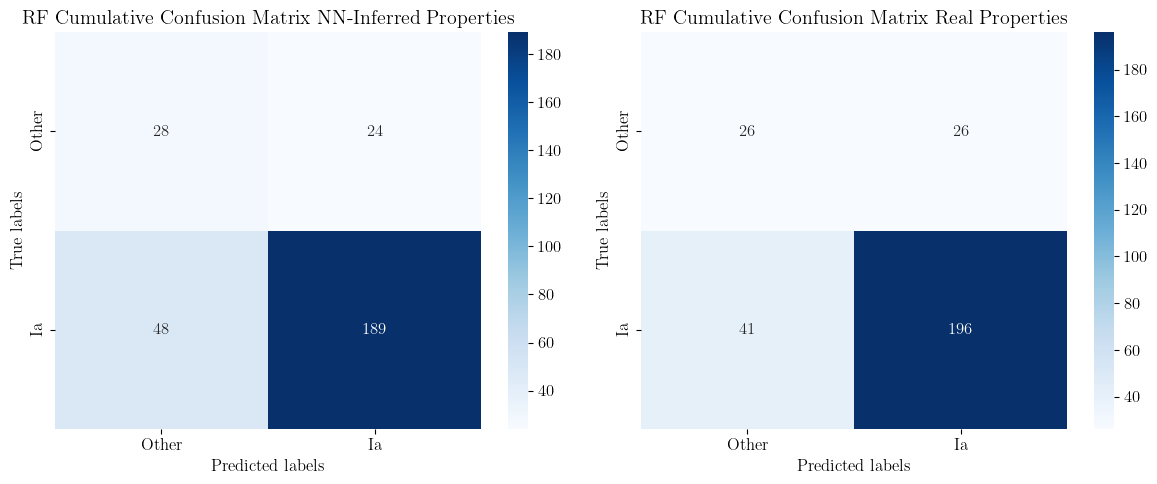

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/2144283338.py:96: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


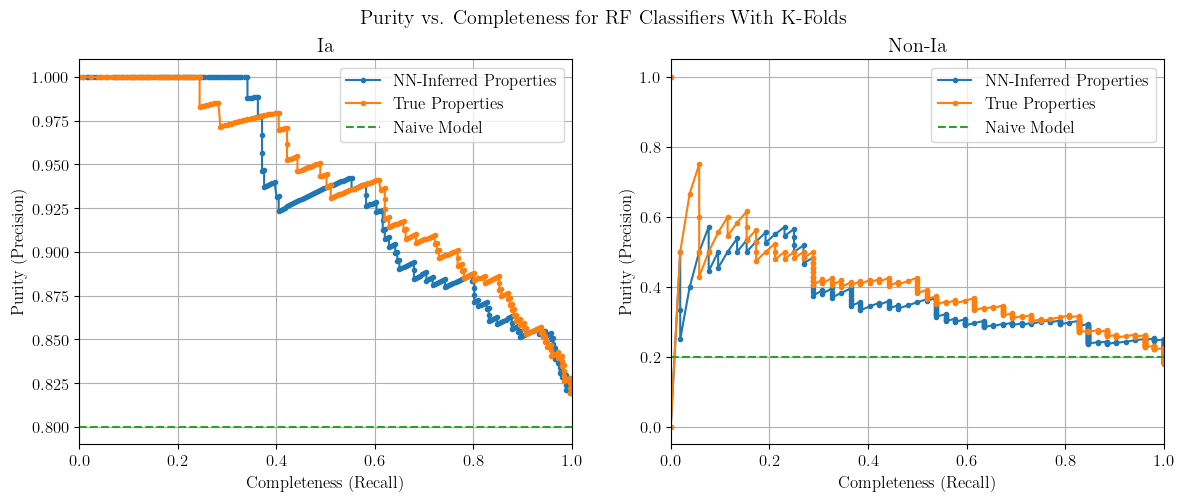

In [32]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=50, random_state=22, shuffle=True)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores = []

# Iterate over each fold
for train_index, test_index in kf.split(sne_props_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)


    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('RF Cumulative Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('RF Cumulative Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid()
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid()

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for RF Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/3559133637.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/3559133637.py:72: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


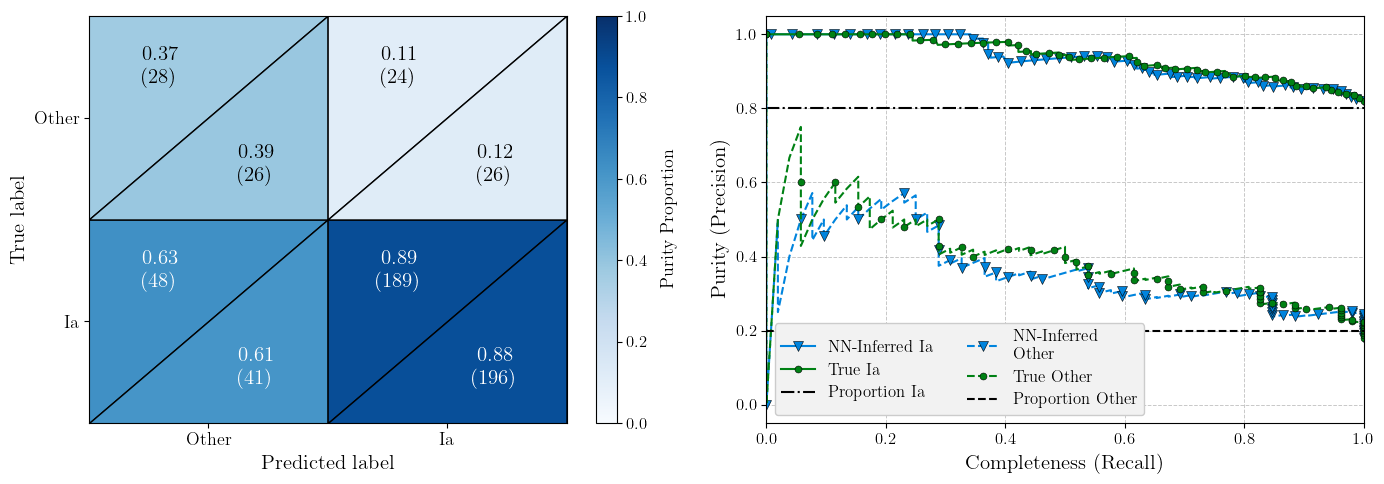

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

### Leave One Out CV

0 / 289
10 / 289
20 / 289
30 / 289
40 / 289
50 / 289
60 / 289
70 / 289
80 / 289
90 / 289
100 / 289
110 / 289
120 / 289
130 / 289
140 / 289
150 / 289
160 / 289
170 / 289
180 / 289
190 / 289
200 / 289
210 / 289
220 / 289
230 / 289
240 / 289
250 / 289
260 / 289
270 / 289
280 / 289


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/153386449.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


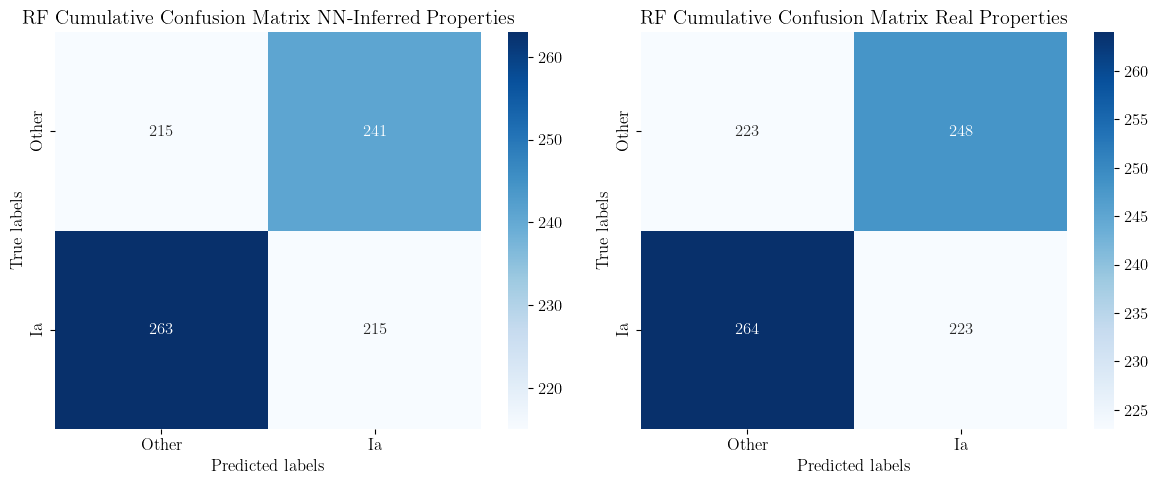

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/153386449.py:96: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


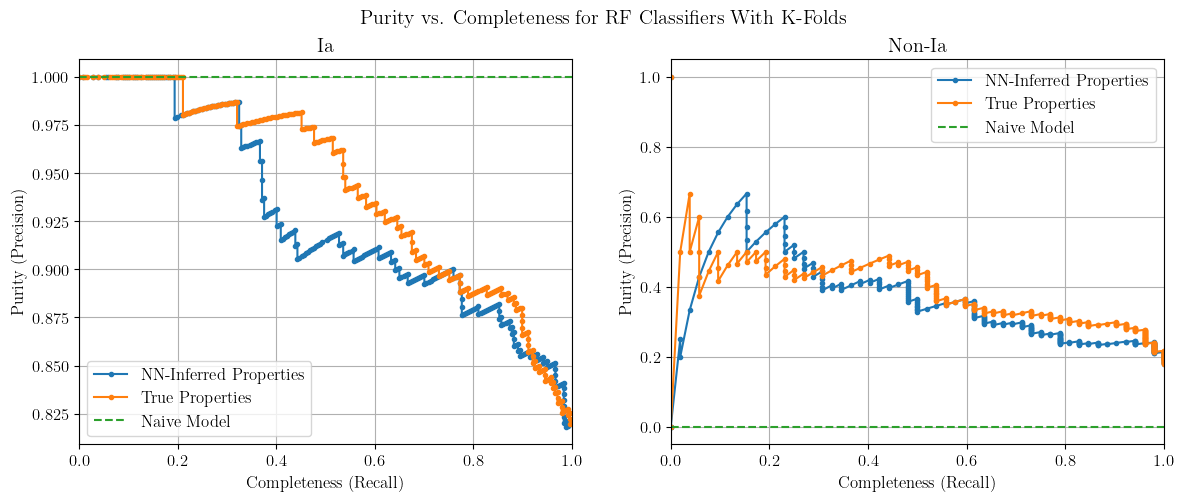

In [34]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []

# Iterate over each sample
for indx, (train_index, test_index) in enumerate(loo.split(sne_props_X)):
    if indx%10==0:
        print(f'{indx} / {len(sne_props_X)}')

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current sample
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Do SMOTE resampling
    X_true_train, y_true_train = smote.fit_resample(X_true_train, y_true_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)


# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('RF Cumulative Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('RF Cumulative Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid()
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid()

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for RF Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/4060300659.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/4060300659.py:66: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


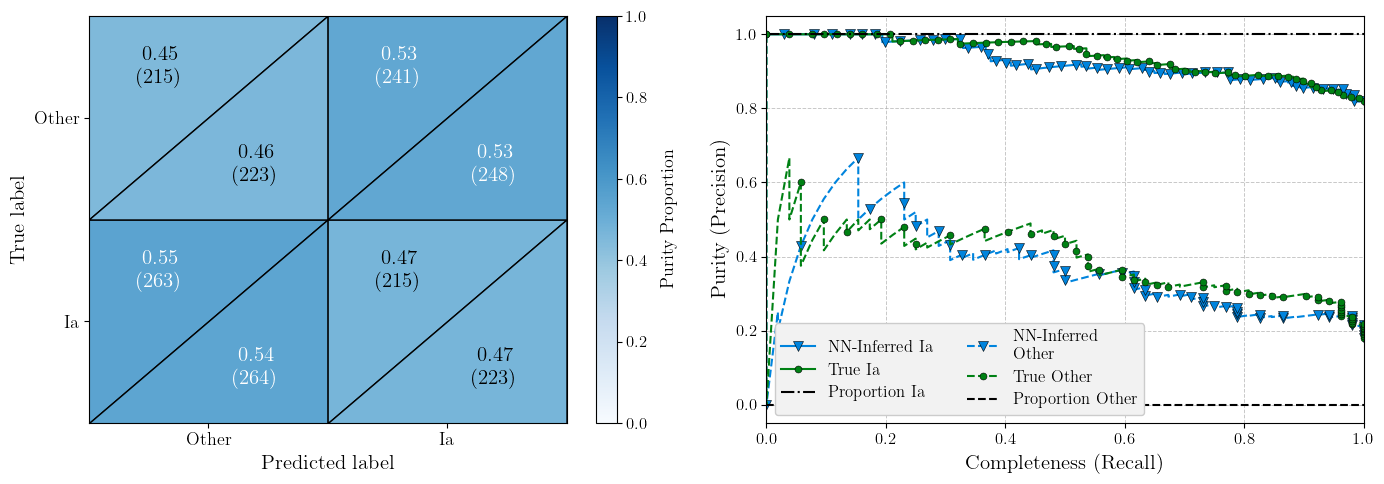

In [35]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/LOO_results.png', dpi=1000)
plt.show()

### Predicting On SEDs only

In [36]:
# Get the SEDs for all the hosts
host_seds_X = gal_props_pred_untrans[host_inds]

In [37]:
# Define the pipeline
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__max_depth': list(np.linspace(2, 31, num=30).astype(int)) + [None]  # List depths you want to test
}

# Get grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(host_seds_X, sne_props_y)
best_max_depth_seds = grid_search.best_params_['classifier__max_depth']
print("Best max depth:", best_max_depth_seds)

Best max depth: 20


In [38]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=50, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth_seds)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores_sed = []

# Iterate over each fold
for train_index, test_index in kf.split(host_seds_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = host_seds_X[train_index], host_seds_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 scores
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores_sed.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/4107686588.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/4107686588.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


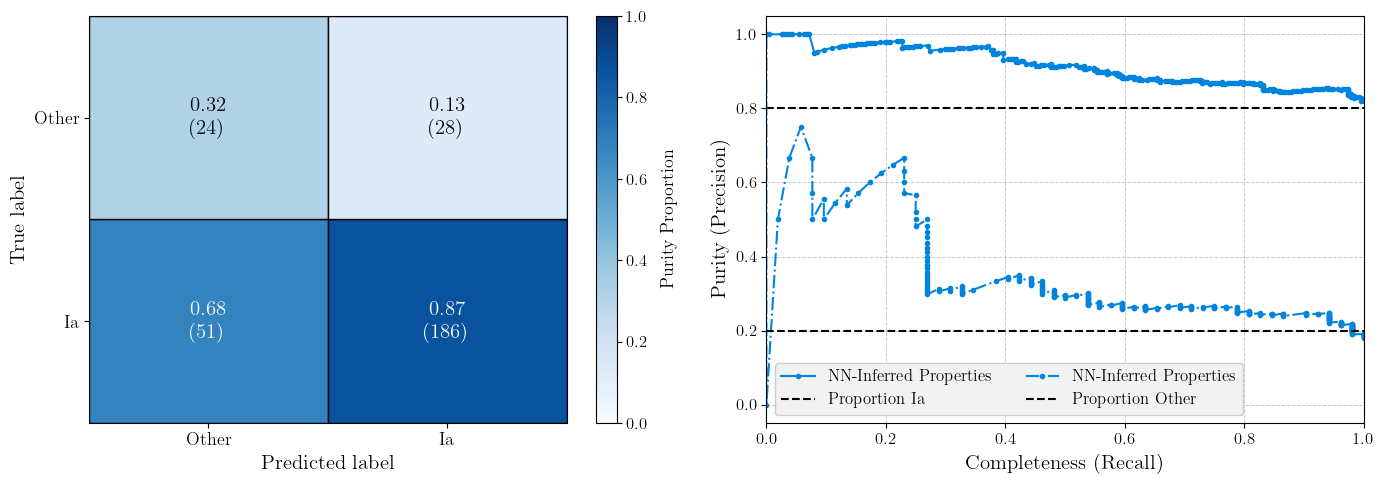

In [39]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(sed_recall, sed_precision, marker='.', label='NN-Inferred Properties', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='NN-Inferred Properties', color='#0084DD', linestyle='-.')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/LOO_results.png', dpi=1000)
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/438499864.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/438499864.py:18: RuntimeWarning: invalid value encountered in divide
  cm2_norm = cm2 / cm2_col_norms
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_77507/438499864.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


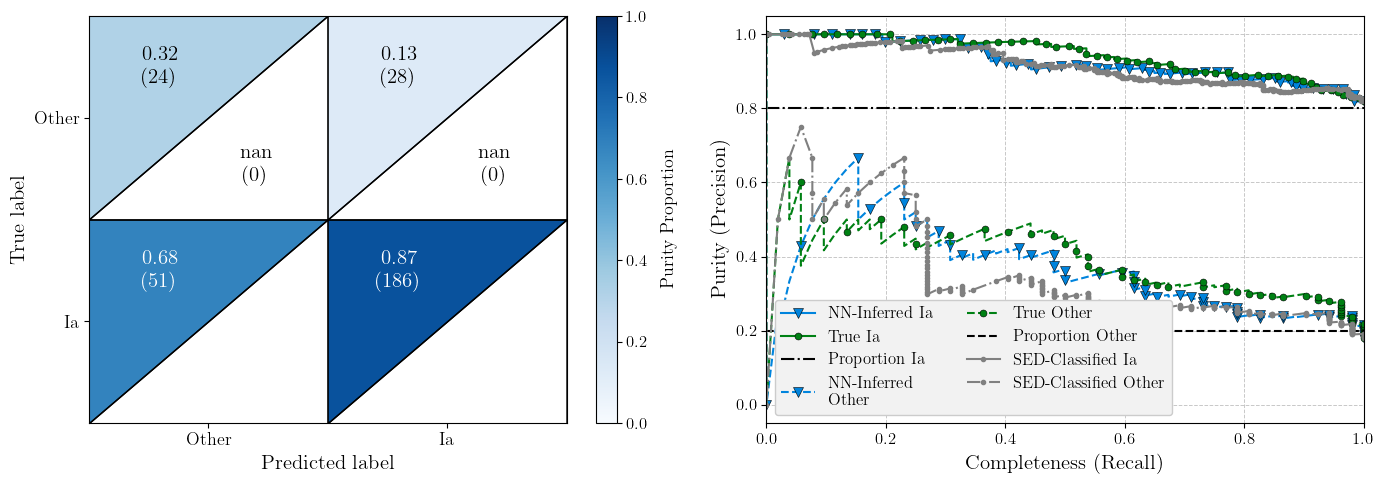

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# SED classifier
ax2.plot(sed_recall, sed_precision, marker='.', label='SED-Classified Ia', color='gray')
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='SED-Classified Other', color='gray', linestyle='-.')

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

In [41]:
# Comparing the F1 scores
print(f'F1 Scores:\n\thost-prop classifier: {np.mean(f1_scores).round(3)} +- {np.std(f1_scores).round(3)}\n\tSED classifier: {np.mean(f1_scores_sed).round(3)} +- {np.std(f1_scores_sed).round(3)}')

F1 Scores:
	host-prop classifier: 0.834 +- 0.119
	SED classifier: 0.816 +- 0.123


## Panstarrs

### Read in Data

In [21]:
print('We seek an array with columns: \n(class, unique_identifier, angular_distance [``], mass, SRF, redshift)')
display(pd.DataFrame(sne_props))

We seek an array with columns: 
(class, unique_identifier, angular_distance [``], mass, SRF, redshift)


,0,1,2,3,4,5
0,0.0,2336057.0,0.037172,10.318529,-0.758992,0.028449
1,0.0,793720.0,0.095110,9.209777,-1.090419,0.643561
2,0.0,1485564.0,0.768109,8.955444,-0.287169,0.331861
3,0.0,776283.0,1.502568,8.462724,-1.040922,0.395303
4,0.0,806358.0,0.309975,9.978939,-0.177889,0.163458
...,...,...,...,...,...,...
284,0.0,1956182.0,0.309108,9.162323,-0.104018,0.628983
285,0.0,1825846.0,1.320941,11.052103,1.294544,0.826373
286,0.0,1780261.0,0.197503,9.128785,-0.022824,0.425279
287,0.0,2038263.0,0.693530,9.786377,0.116326,0.571616


In [22]:
def propocess_tab(table: ascii.Tab) -> pd.DataFrame:

    # Make and format a pd dataframe
    df: pd.DataFrame = table.to_pandas()
    column_types = {col: float for col in df.columns[:-2]}
    column_types[df.columns[-2]] = str
    column_types[df.columns[-1]] = float
    df = df.astype(column_types)
    df.replace('nan', np.nan, inplace=True)

    # The columns of grizy mags
    sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

    # Drop rows where the specified columns have more than 4 NaN values
    orig_len = len(df)
    df = df.dropna(thresh=3, subset=sed_cols, ignore_index=True)
    df = df.dropna(subset=['sn_class'], ignore_index=True)
    print(f'Dropped {orig_len - len(df)}/{orig_len} rows due to missingness. Now have {len(df)}')

    # Function to calculate angular separation
    def angular_separation(ra1, dec1, ra2, dec2):
        coord1 = SkyCoord(ra1, dec1, unit='deg')
        coord2 = SkyCoord(ra2, dec2, unit='deg')
        return coord1.separation(coord2).arcsec

    # Apply the function to each row
    df['angular_separation_arcsec'] = df.apply(lambda row: angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec']), axis=1)

    return df

In [23]:
# Get the preprocessed pstar data
panstarr_tab = ascii.read("/Users/adamboesky/Research/ay98/clean_data/panstarrs_hosts_pcc_final.ecsv", delimiter=' ', format='ecsv')
panstarr_df = propocess_tab(panstarr_tab)

Dropped 683/10090 rows due to missingness. Now have 9407


### Domain Transfer

In [24]:
pstar_photo_mag = panstarr_df[['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi']].to_numpy()
pstar_photo_err_mag = panstarr_df[['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi']].to_numpy()

In [25]:
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

# Convert the data from mags to flux
pstar_photo = ab_mag_to_flux(pstar_photo_mag)
pstar_photo_err = ab_magerr_to_ferr(pstar_photo_err_mag, pstar_photo)

In [26]:
# Impute missing data
pstar_photo_imputed = np.isnan(pstar_photo)
imputer = KNNImputer(n_neighbors=5)
pstar_photo = imputer.fit_transform(pstar_photo)
pstar_photo_err = imputer.fit_transform(pstar_photo_err)

In [27]:
# Training parameters
nodes_per_layer = [7, 9, 11, 13]
num_linear_output_layers = 1
torch.set_default_dtype(torch.float64)
sed_model = get_model(num_inputs=5, num_outputs=13, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)

# Load best model
resume(sed_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_sed_model.pkl')
sed_model.eval()

Sequential(
  (input): Linear(in_features=5, out_features=7, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=7, out_features=9, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=9, out_features=11, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=11, out_features=13, bias=True)
  (act_2): ReLU()
  (output): Linear(in_features=13, out_features=13, bias=True)
)

In [28]:
def normalize_arr(arr: np.ndarray, errors: np.ndarray = None, axis: int = 0, mean: float = None, std: float = None) -> (float, float, float, Optional[np.ndarray]):
    """Normalize numpy array along given axis and its errors if given."""
    if mean is None:
        mean = np.mean(arr, axis=axis, keepdims=True)
    if std is None:
        std = np.std(arr, axis=axis, keepdims=True)
    if not errors is None:
        return (arr - mean) / std, mean[0], std[0], errors / std
    else:
        return (arr - mean) / std, mean, std

In [29]:
# get mean and std to normalize the data
from sed_nn import load_and_preprocess
_, _, _, _, _, _, _, _, _, photo_mean, photo_std, photo_err_norm = load_and_preprocess()

# Apply log transform to the SEDs
pstar_photo_err = np.abs(pstar_photo_err / (pstar_photo * np.log(10)))
pstar_photo = np.log10(pstar_photo)

# Normalize data
pstar_photo_norm, pstar_photo_mean, pstar_photo_std, ptar_photo_err_norm = normalize_arr(pstar_photo, errors=pstar_photo_err, mean=photo_mean[:5], std=photo_std[:5])

2024-03-31 01:11:18,176 - sed_nn.py - INFO - Importing photometry data
2024-03-31 01:11:21,969 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-03-31 01:11:21,983 - sed_nn.py - INFO - Importing photometry data
2024-03-31 01:11:24,370 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  0.92884049 -2.42786271 -2.2128036  -1.99193711
 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 1.35729201 2.21415807 2.12945886 2.02186998
 0.66726908 0.69343955]
2024-03-31 01:11:24,372 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-03-31 01:11:24,373 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-03-31 01:11:24,986 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH2', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']


In [30]:
# Predict SEDs
pstar_sed_preds = sed_model(torch.from_numpy(pstar_photo_norm)).detach().numpy()
pstar_full_pred = np.hstack((pstar_photo_norm, pstar_sed_preds))  # note that this is still scaled to be input into the host prop NN

### Predict Host Properties

In [31]:
classification_groups = [['ia'], ['ib', 'ic'], ['slsn'], ['iin'], ['ii', 'iip', 'ii p', 'iil', 'ii l']]

def add_sn_class_cols(df: pd.DataFrame) -> pd.DataFrame:
    # Ia or other
    ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in df['sn_class']], dtype=str)), 'ia') != -1
    df['sn_class_binary'] = ia_mask.astype(int)

    # Ia, II, or other
    # Conditions to check for 'ii' or 'ia' in a case-insensitive manner
    condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
    condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

    # Apply conditions and choices to the string array
    df['sn_class_tertiary'] = np.where(condition_ia(df['sn_class']), 0, np.where(condition_ii(df['sn_class']), 1, 2))

    # Your classification groups

    def add_category_id_column(my_df, classification_groups):
        # Convert classification groups to lowercase and assign unique integers to each category
        lowercase_groups = {cls.lower(): i for i, group in enumerate(classification_groups) for cls in group}

        # Function to get the category id for a supernova class
        def get_category_id(sn_class_list):
            for sn_class in sn_class_list:
                sn_class_lower = sn_class.lower()
                for group, group_id in lowercase_groups.items():
                    if group in sn_class_lower:
                        return group_id
            return np.max(list(lowercase_groups.values())) + 1  # Return a default id if no category is found

        # Add 'category_id' column to the DataFrame
        my_df['sn_class_cat'] = my_df['sn_class'].apply(lambda x: get_category_id(x.split(',')))

        return my_df

    # Apply the function to the DataFrame
    df = add_category_id_column(df, classification_groups)
    for idx, snt in enumerate(('ia', 'ib/c', 'slsn', 'iin', 'ii (p/l)')):
        print(f'The data are {np.round(len(df[df["sn_class_cat"] == idx]) / len(df) * 100, 2)}% type {snt} with n = {len(df[df["sn_class_cat"] == idx])}')

    return df

In [32]:
# Add columns that denote the SN classes
panstarr_df = add_sn_class_cols(panstarr_df)
panstarr_df

The data are 68.28% type ia with n = 6423
The data are 6.96% type ib/c with n = 655
The data are 0.84% type slsn with n = 79
The data are 2.77% type iin with n = 261
The data are 16.57% type ii (p/l) with n = 1559


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,1.839010e+17,101.257336,63.249727,1.0,20.2123,19.4741,19.6845,19.6740,19.7830,0.024837,...,0.093262,0.000000,101.257000,63.249972,II P,NaN,1.036981,0,1,4
1,8.326343e+16,343.097793,-20.610464,1.0,16.2329,15.8255,15.6137,15.5744,15.3857,0.002976,...,0.007104,0.132961,343.097708,-20.614917,Ia,0.033150,16.031356,1,0,0
2,1.479104e+17,35.504167,33.266051,1.0,12.5022,11.7593,11.3363,11.3089,11.2106,0.000230,...,0.000387,0.236131,35.499917,33.270472,Ia,0.013269,20.419790,1,0,0
3,1.072924e+17,244.140958,-0.588824,1.0,16.1156,15.7253,15.5693,15.4091,15.2103,0.001789,...,0.004224,0.038113,244.141917,-0.590944,Ia,0.016460,8.378815,1,0,0
4,1.134624e+17,244.296033,4.554083,1.0,15.6716,14.9574,14.5674,14.3897,14.2283,0.001545,...,0.002459,0.155941,244.295875,4.554083,Ia,0.018000,0.565643,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9402,1.707714e+17,137.507912,52.315744,1.0,19.6314,19.2990,19.1074,19.1259,19.5551,0.016346,...,0.079351,0.000000,137.507750,52.315611,Ia,0.040000,0.598116,1,0,0
9403,1.281323e+17,225.325442,16.777947,1.0,15.4860,14.8218,14.3426,14.0982,13.8556,0.001806,...,0.002709,0.133899,225.329750,16.779972,Ia,0.050000,16.543153,1,0,0
9404,1.096604e+17,39.531415,1.388424,1.0,15.0879,15.9814,14.1134,13.9812,13.7094,0.002940,...,0.003266,0.186789,39.530375,1.391444,"IIb,II",0.022900,11.499092,0,1,1
9405,1.164508e+17,78.699637,7.048043,1.0,16.6697,15.7644,15.2988,14.9323,14.7282,0.002636,...,0.002772,0.083613,78.699167,7.050361,"Ia,Ia-91T,I",0.050500,8.510967,1,0,0


In [33]:
print('Non-Ia/Insufficient Classifications: ', panstarr_df['sn_class'][panstarr_df['sn_class_cat'] == 5].unique())

non_ia_class_df = panstarr_df[panstarr_df['sn_class_cat'] != 5]

Non-Ia/Insufficient Classifications:  ['removed' 'NT' 'Other' 'BL' 'other' 'Say1' 'I' 'Afterglow' 'LGRB' 'XRB'
 'BL,BL Lac' 'Jovan' 'CN' 'Radio' 'ILRT' 'Iz' 'I,TDE']


In [34]:
def filter_unique_multiple_categories(df, classification_groups):
    # Convert classification groups to lowercase
    lowercase_groups = [[cls.lower() for cls in group] for group in classification_groups]

    # Function to check if a class belongs to multiple unique categories
    def belongs_to_multiple_unique_categories(sn_class_list):
        categories_matched = set()
        for sn_class in sn_class_list:
            sn_class_lower = sn_class.lower()
            for i, group in enumerate(lowercase_groups):
                if sn_class_lower in group:
                    categories_matched.add(i)
                    break
        return len(categories_matched) > 1

    # Filter DataFrame with case insensitive comparison and handling comma-separated classes
    return df[df['sn_class'].apply(lambda x: belongs_to_multiple_unique_categories(x.split(',')))]

# Apply the function to the DataFrame
multiple_class_df = filter_unique_multiple_categories(panstarr_df, classification_groups)
print(len(multiple_class_df))
for i in range(len(multiple_class_df)):
    print(str(int(multiple_class_df['objID_3pi'].iloc[i])), '\t\t', multiple_class_df['sn_class'].iloc[i])

24
183901012573690336 		 Ia,II
115742251149866144 		 II,Ia,Ia-91bg
97853509906337936 		 IIn,II
109061678181601264 		 IIn?,II,IIn
102381528992336816 		 II,Ic
116612461763719584 		 IIn,II
98651839064753408 		 II,Ia,II P
115681448469792448 		 Ia,Ic
172272150455194752 		 IIn,II
203741971565915264 		 Ia,II,IIb
113870203451860704 		 II,IIn
147232446484447360 		 II,Ia
110382603003816400 		 Ic,Ia
142513462517664096 		 II,Ic
87792149356024656 		 II,IIn
189892330034466272 		 II,IIn
124432151791835856 		 II,Ia
160263258891031776 		 IIn,II
158891332359198784 		 IIn,II
98330267154683840 		 Ib,Ia
147030410013305760 		 Ia,Ic
127110585665664896 		 Ic,Ia
97410595434384944 		 IIn,II
156522473593907200 		 Ia,II


In [35]:
# sne[bad_class_df['SN_ra'] == sne_ra[0]]
for i in range(len(multiple_class_df)):
    mask = (multiple_class_df['SN_ra'].to_numpy()[i] == sne_ra) & (multiple_class_df['SN_dec'].to_numpy()[i] == sne_dec)
    print(str(sne[mask]['name'].values[0]), '\t\t\t\t', str(sne[mask]['claimedtype'].values[0]))

ASASSN-15ug 				 Ia,II
ASASSN-15ul 				 II,Ia,Ia-91bg
ESSENCEm139 				 IIn,II
GRETA 				 IIn?,II,IIn
LSQ15hj 				 II,Ic
PS1-14pi 				 IIn,II
PS15at 				 II,Ia,II P
PS15cyo 				 Ia,Ic
PTF09uj 				 IIn,II
PTF10htz 				 Ia,II,IIb
PTF10uls 				 II,IIn
PTF11dsb 				 II,Ia
SN2016eld 				 Ic,Ia
SN2017gip 				 II,Ic
SN2017lt 				 II,IIn
SN2018bek 				 II,IIn
SN2018btr 				 II,Ia
SN2018dfy 				 IIn,II
SN2018hfg 				 IIn,II
SN2018jgs 				 Ib,Ia
SN2019wzj 				 Ia,Ic
SN2020rvf 				 Ic,Ia
SN2020svn 				 IIn,II
SN2021th 				 Ia,II


In [36]:
from host_prop_nn import load_and_preprocess

# Predict the properties
pstar_props_unnorm = model(torch.from_numpy(pstar_full_pred)).detach().numpy()

# Scale the properties by the Zou mean and std
test, _, _, _, _, _, _, _, _, _, _, _, _, _, _, cat_mean, cat_std, _ = load_and_preprocess()
pstar_props = pstar_props_unnorm * cat_std + cat_mean

2024-03-31 01:11:25,678 - host_prop_nn.py - INFO - Importing photometry data
2024-03-31 01:11:27,582 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-03-31 01:11:27,591 - host_prop_nn.py - INFO - Importing photometry data
2024-03-31 01:11:29,242 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.87849839 -2.79518071 -2.78359176 -2.63765973 -2.66592091 -1.33953981
  0.06383305  0.67075717  1.34771103  0.91141463  1.33652476  1.2116005
  1.32755404 -2.41376848 -2.20197162 -1.97797089 -3.03436027 -3.03643454]
 	std = [0.63162979 0.70187988 0.68387317 0.72578209 0.7777774  0.88136263
 1.62222597 2.06392269 0.43210206 1.36265575 0.50050502 0.43821229
 0.46058673 2.21595863 2.13270738 2.02278681 0.67246779 0.70040306]
2024-03-31 01:11:29,244 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 8.87088133 -0.46037044  0.58991822]
 	std = [1.08494612 1.04024203 0.2700682 ]
2024-03-31 01:11:29,245 - host_prop_nn.py - INFO - Length = 1200550


HEEERRRREE [[ 0.69879328  1.44090157  0.141008  ]
 [-0.5611702   0.68871811  0.84083122]
 [-0.49142539  0.80762344  0.5149876 ]
 ...
 [ 0.56822286 -1.04936127  0.70753156]
 [-1.45187574 -0.5911653  -0.31813528]
 [-0.55335552 -0.57962198 -0.99574189]]
[ 8.87088133 -0.46037044  0.58991822]


In [37]:
# Make a df
sne_df = pd.DataFrame(np.hstack((panstarr_df[['sn_class_cat', 'angular_separation_arcsec']], pstar_props)), columns=[r'Supernova Type', r'$\log(\rm{Separation})$ [$^{\prime\prime}$]', r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$]', r'Redshift'])
sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = pd.to_numeric(sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'], errors='coerce')
sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = np.log10(sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'])

# # Reorder for zorder
# sne_df = pd.concat([sne_df[sne_df[r'Supernova Type'] == 0], sne_df[sne_df[r'Supernova Type'] == 1], sne_df[sne_df[r'Supernova Type'] == 2]])

# Filter for everything predicted to be z \in [0, 1]
z_mask = (sne_df['Redshift'] < 1) & (sne_df['Redshift'] > 0)
print(np.sum(~z_mask), len(z_mask))

# Filter for within 4 stdevs of training data
within_training_mask = np.all((pstar_props_unnorm < 4) & (pstar_props_unnorm > -4), axis=1)
print(np.sum(~within_training_mask), len(within_training_mask))

91 9407
1 9407


In [38]:
# Create a mask indicating whether each row in df1 is in the joined DataFrame
good_class_mask = ~panstarr_df.isin(multiple_class_df.to_dict(orient='list')).all(axis=1) & panstarr_df.isin(non_ia_class_df.to_dict(orient='list')).all(axis=1)
print(np.sum(~good_class_mask))

454


/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/axisgrid.py:1282: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axes = fig.subplots(len(y_vars), len(x_vars),
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/axisgrid.py:1459: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  diag_ax = ax.twinx()
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's', 'linewidth'
  cset = contour_func(
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 's', 'linewidth'
  cset = contour_func(
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The followin

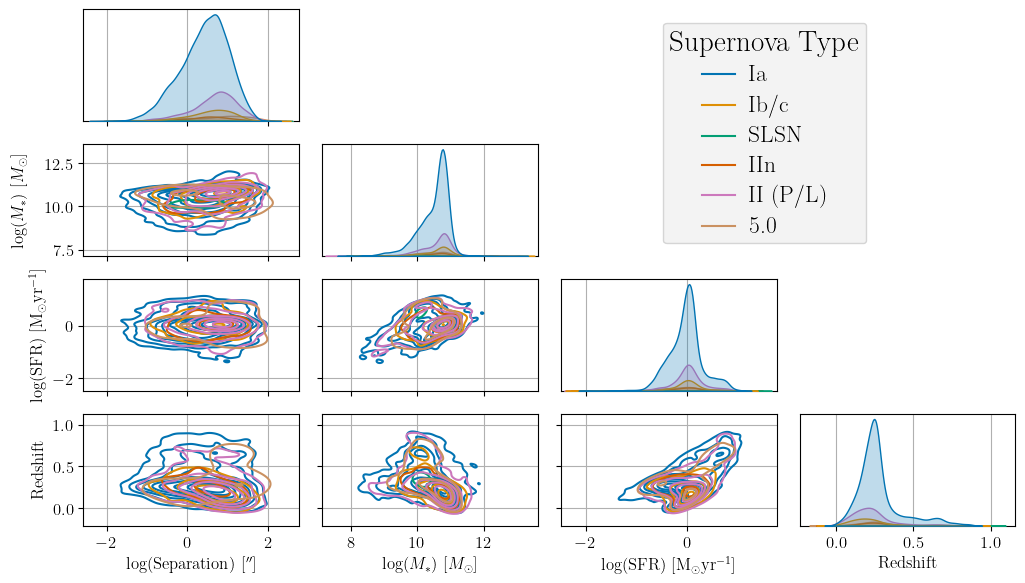

In [39]:
mpl.rcParams["legend.facecolor"] = '#F0F0F0'
markers = ['o', 's', 'v']
plot_kws=dict(s=30, linewidth=0.0000001)#, edgecolor='k')
pp = sns.pairplot(sne_df[within_training_mask & z_mask], hue='Supernova Type', height=1.5, palette='colorblind', corner=True, aspect=1.5, markers=markers, plot_kws=plot_kws, kind='kde')

# Update the legend labels for following cats: [['ia'], ['ib', 'ic'], ['slsn'], ['iin'], ['ii', 'iip', 'ii p', 'iil', 'ii l']]
# label_dict = {'0.0': 'Ia', '1.0': 'II', '2.0': 'Other'}
label_dict = {'0.0': 'Ia', '1.0': 'Ib/c', '2.0': 'SLSN', '3.0': 'IIn', '4.0': 'II (P/L)'}
for t, l in zip(pp._legend.texts, label_dict.values()):  # Update the texts in the legend
    t.set_text(l)

for ax in pp.axes.flatten():
    if ax is not None:
        ax.set_axisbelow(True)
        ax.grid(True, zorder=-1)  # Adds grid lines
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

for i_row, row in enumerate(pp.axes):
    for i_col, ax in enumerate(row):
        if i_row == i_col:
            ax.spines['top'].set_visible(True)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['bottom'].set_visible(True)

plt.subplots_adjust(right=0.85)  # Adjust subplot to make room
pp._legend.set_bbox_to_anchor((0.85, 0.75))  # Anchor the legend
plt.tight_layout()
pp._legend.get_title().set_fontsize('21')  # for legend title
for t in pp._legend.texts:
    t.set_fontsize('17')  # for legend text
for lh in pp._legend.legendHandles: 
    lh.set_markersize(10)  # Set marker size

# Adjusting the y-axis labels
for indx, ax in enumerate(pp.axes[:, 0]):  # Loop over the leftmost axes
    if ax is not None:
        if indx == 1:
            ax.yaxis.labelpad = 13  # Adjust this value to move the y-axis label
        else:
            ax.yaxis.labelpad = 5  # Adjust this value to move the y-axis label
pp._legend.set_frame_on(True)

plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/pairplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_74686/3485026056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Supernova Type'] = df['Supernova Type'].astype(str).map(label_dict)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_74686/3485026056.py:19: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(len(numeric_columns), len(numeric_columns), figsize=(17, 13))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/s

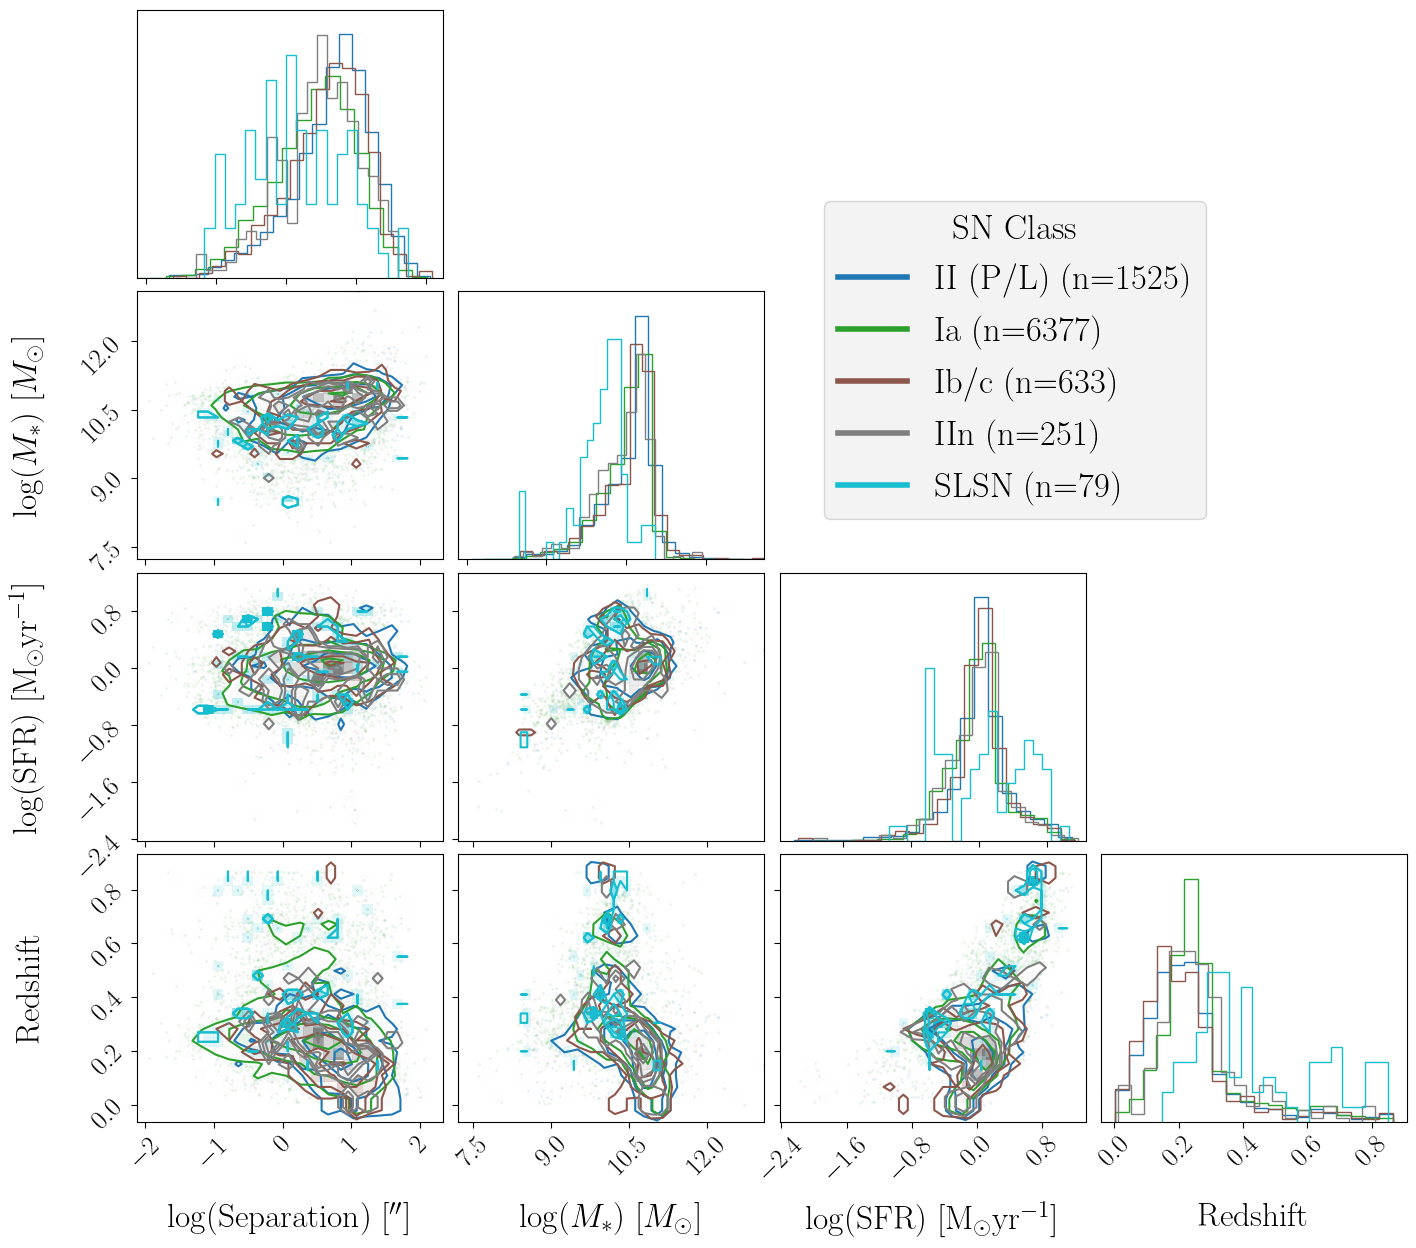

In [40]:
import corner

# Assuming 'sne_df' is your DataFrame and 'within_training_mask' & 'z_mask' are your conditions
df = sne_df[within_training_mask & z_mask & good_class_mask]

# Update the DataFrame to use the label dictionary for 'Supernova Type'
label_dict = {'0.0': 'Ia', '1.0': 'Ib/c', '2.0': 'SLSN', '3.0': 'IIn', '4.0': 'II (P/L)'}
df['Supernova Type'] = df['Supernova Type'].astype(str).map(label_dict)

# Define colors for each type
colors = plt.cm.tab10(np.linspace(0, 1, len(df['Supernova Type'].unique())))

# Filter only numeric columns for plotting
numeric_columns = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
axis_labels = [col for col in numeric_columns]
label_kwargs = {'fontsize': 24, 'labelpad': -100}  # Adjust the labelpad as needed

# Create a figure
fig, axes = plt.subplots(len(numeric_columns), len(numeric_columns), figsize=(17, 13))

# Plot each subset separately with density histograms on the diagonal
for i, (supernova_type, color) in enumerate(zip(df['Supernova Type'].unique(), colors)):
    hist_kwargs = {'density': True, 'color': color}
    subset = df[df['Supernova Type'] == supernova_type][numeric_columns]
    corner_plot = corner.corner(subset, color=color, fig=fig, hist_kwargs=hist_kwargs, labels=axis_labels, label_kwargs=label_kwargs)

    # Color the histograms on the diagonal
    for j in range(len(numeric_columns)):
        ax = corner_plot.axes[j + len(numeric_columns) * j]
        for patch in ax.patches:
            patch.set_facecolor(color)

# Decrease the label padding
for ax in fig.axes:
    ax.xaxis.labelpad = -50
    ax.yaxis.labelpad = -50
    ax.tick_params(axis='both', which='major', labelsize=19, length=4)

# Customizing the plot appearance
mpl.rcParams["legend.facecolor"] = '#F0F0F0'
plt.subplots_adjust(right=0.85)
# plt.tight_layout()

# Adding a legend
legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=supernova_type + f"     (n={len(df[df['Supernova Type'] == supernova_type])})") for supernova_type, color in zip(df['Supernova Type'].unique(), colors)]
plt.legend(handles=legend_elements, fontsize='25', bbox_to_anchor=(0.4, 3.5), frameon=True, title='SN Class', title_fontsize='25')

plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/pairplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Classify OSC SNe

#### IA v. Other

In [47]:
best_max_depth = 20

In [45]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)
# smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22, max_depth=best_max_depth)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []
f1_scores = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_binary'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

In [46]:
print(f'f1_score = {np.mean(f1_scores)}')
print(f'Accuracy = {(cumulative_cm[0,0] + cumulative_cm[1,1]) / (cumulative_cm[0,0] + cumulative_cm[0,1] + cumulative_cm[1,0] + cumulative_cm[1,1])}')

f1_score = 0.8246418461630283
Accuracy = 0.7211505922165821


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/2686895456.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/2686895456.py:68: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


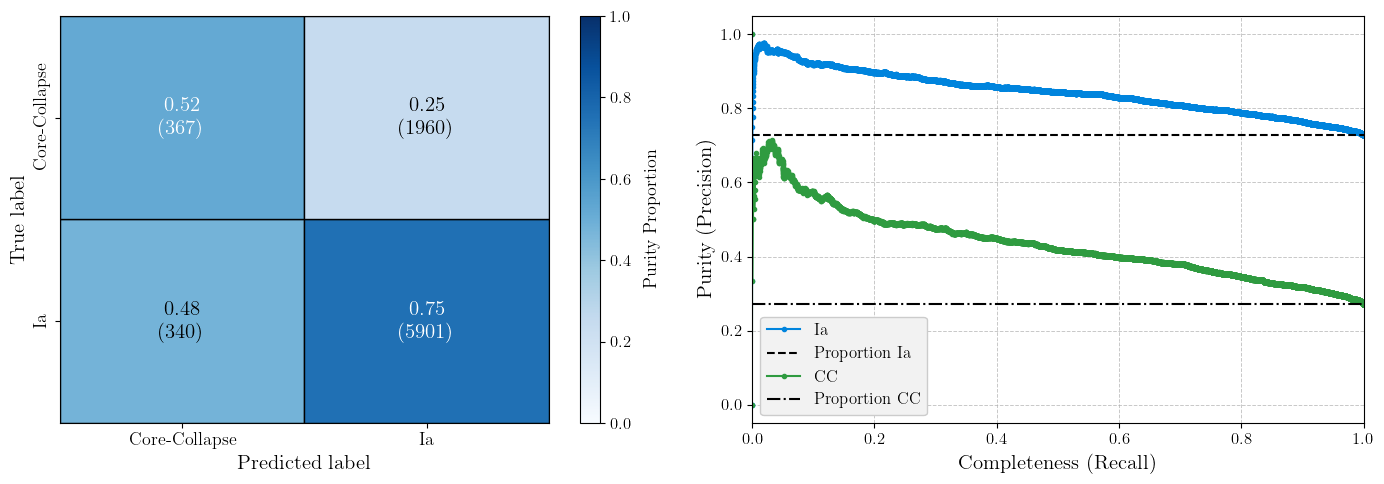

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Core-Collapse", "Ia"])
ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)



# Ia
ax2.plot(sed_recall, sed_precision, marker='.', label='Ia', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, marker='.', label='CC', color='#2F9B40')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion CC', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/panstarrs_classification_results.pdf', bbox_inches='tight')
plt.show()

In [39]:
# Initialize a matrix to hold the summed confusion matrix
cumulative_cm_sed_only = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_sed_only = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests_sed_only = []
y_proba_sed_only = []
f1_scores_sed_only = []

# X and y set
preds = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
pstar_sed_X = pstar_photo[within_training_mask & z_mask & good_class_mask]
pstar_sed_y = panstarr_df['sn_class_binary'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_sed_X, pstar_sed_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_sed_X[train_index], pstar_sed_X[test_index]
    y_train, y_test = pstar_sed_y[train_index], pstar_sed_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm_sed_only += confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests_sed_only.append(y_test)
    y_proba_sed_only.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='binary')  # Adjust the 'average' parameter as needed
    f1_scores_sed_only.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/1553517016.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/1553517016.py:76: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


Didn't concat


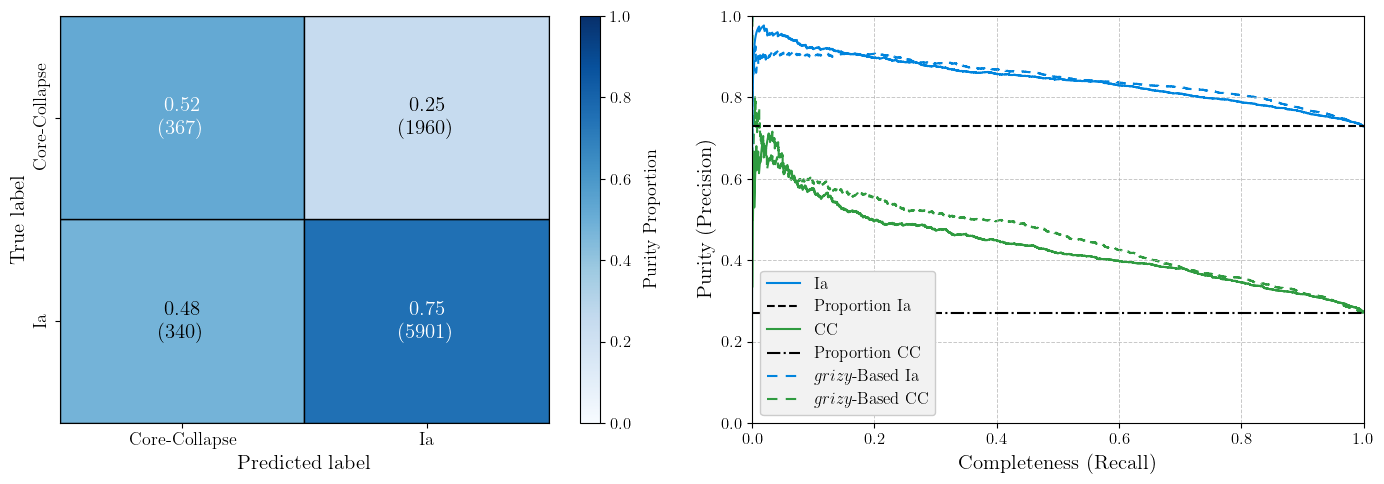

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

try:
    y_tests_sed_only = np.concatenate(y_tests_sed_only)
    y_proba_sed_only = np.concatenate(y_proba_sed_only)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba)
sed_precision_sed_only, sed_recall_sed_only, thresholds_sed_only = precision_recall_curve(y_tests_sed_only, y_proba_sed_only)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
sed_precision_0_sed_only, sed_recall_0_sed_only, thresholds_0_sed_only = precision_recall_curve(y_tests_sed_only, 1 - y_proba_sed_only, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Core-Collapse", "Ia"])
ax1.set_yticklabels(["Ia", "Core-Collapse"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)


# HOST-PROP CLASSIFICATIONS
# Ia
ax2.plot(sed_recall, sed_precision, label='Ia', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, label='CC', color='#2F9B40')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion CC', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
# SED ONLY CLASSIFICATIONS
line1 = ax2.plot(sed_recall_sed_only, sed_precision_sed_only, label=r'$grizy$-Based Ia', color='#0084DD', zorder=-1, linestyle='-')
line1[0].set_dashes([5, 4])  # Increase the spacing between dashes
# Non-Ia
line2 = ax2.plot(sed_recall_0_sed_only, sed_precision_0_sed_only, label=r'$grizy$-Based CC', color='#2F9B40', zorder=-1, linestyle='--')
line2[0].set_dashes([5, 4])  # Increase the spacing between dashes

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
ax2.legend(fancybox=True, loc='lower left', framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/panstarrs_classification_results.pdf', bbox_inches='tight')
plt.show()

#### 5-Classes

In [87]:
# Define the pipeline
pipeline = IMBPipeline([
    ('classifier', OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, random_state=22)))
])

# Parameters for GridSearchCV
param_grid = {
    'classifier__estimator__max_depth': list(np.linspace(2, 31, num=30).astype(int)) + [None]  # List depths you want to test
}

# Data we want to grid search on
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Get grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(pstar_X, pstar_y)
best_max_depth_5_class = grid_search.best_params_['classifier__estimator__max_depth']
print("Best max depth:", best_max_depth_5_class)

Best max depth: 4


In [55]:
rf_classifier_multi.feature_importances_

array([0.24778065, 0.2492906 , 0.24912374, 0.25380501])

In [54]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=20, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
rf_classifier_multi =  RandomForestClassifier(n_estimators=1000, random_state=22, class_weight={0: 8.0, 1: 1.0, 2: 8.0, 3: 4.0, 4: 1.0})

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0 for _ in range(5)] for _ in range(5)])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
f1_scores = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi.fit(X_train, y_train)
    y_pred = rf_classifier_multi.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi.predict_proba(X_test)
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

In [57]:
d1 = [{1:2}]
d2 = [{1:2}, {3:4}]
for d in d2:
    if d not in d1:
        print(d)

{3: 4}


In [ ]:
# Initialize a matrix to hold the summed confusion matrix
cumulative_cm_sed_only = np.array([[0 for _ in range(5)] for _ in range(5)])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests_sed_only = []
y_proba_sed_only = []
f1_scores_sed_only = []

# X and y set
preds = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
pstar_sed_X = pstar_photo[within_training_mask & z_mask & good_class_mask]
pstar_sed_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_sed_X, pstar_sed_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_sed_X[train_index], pstar_sed_X[test_index]
    y_train, y_test = pstar_sed_y[train_index], pstar_sed_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi.fit(X_train, y_train)
    y_pred = rf_classifier_multi.predict(X_test)
    cumulative_cm_sed_only += confusion_matrix(y_test, y_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi.predict_proba(X_test)
    y_tests_sed_only.append(y_test)
    y_proba_sed_only.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust the 'average' parameter as needed
    f1_scores_sed_only.append(f1)

KeyboardInterrupt: 

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_3738/3888199082.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_3738/3888199082.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


NameError: name 'y_tests_sed_only' is not defined

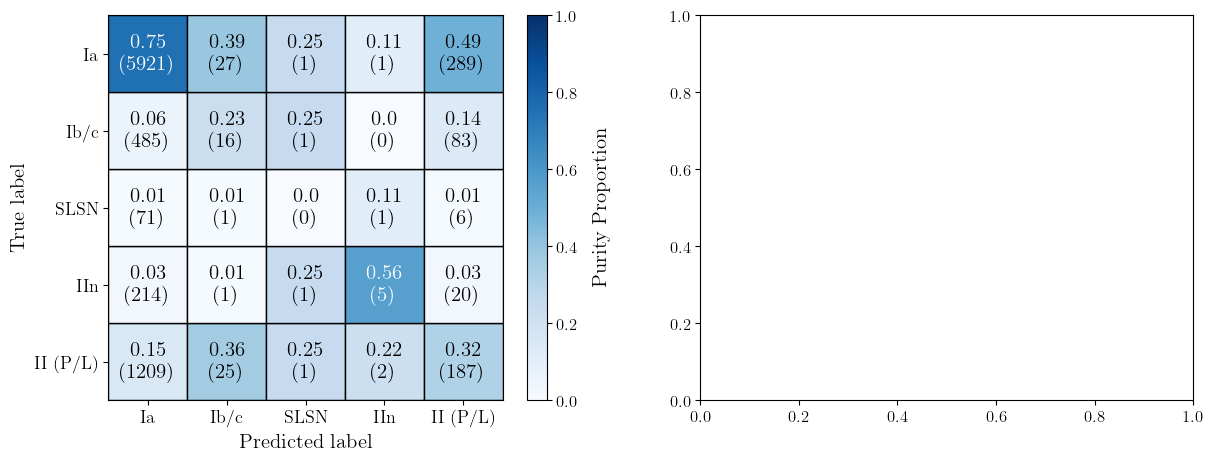

In [54]:
# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(cumulative_cm)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Concatenate the arrays in y_tests and y_proba
# if y_tests.ndim != 1:
y_tests_concatenated = np.concatenate(y_tests)
y_proba_concatenated = np.concatenate(y_proba, axis=0)
# if y_tests_sed_only.ndim != 1:
y_tests_sed_only_concatenated = np.concatenate(y_tests_sed_only)
y_proba_sed_only_concatenated = np.concatenate(y_proba_sed_only, axis=0)

# Ensure y_proba_concatenated is a 2D array
if y_proba_concatenated.ndim == 1:
    y_proba_concatenated = y_proba_concatenated.reshape(-1, 1)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (y_tests_concatenated == i)
    proba_binary = y_proba_concatenated[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

    # Treat class i as the positive class
    true_binary = (y_tests_sed_only_concatenated == i)
    proba_binary = y_proba_sed_only_concatenated[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    line = ax2.plot(recall, precision, color=color, lw=2)
    line[0].set_dashes([5, 4])  # Increase the spacing between dashes

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
grizy = mlines.Line2D([], [], color='gray', linestyle='--', label=r'$grizy$-Based')
handles, labels = ax2.get_legend_handles_labels()
handles.append(grizy)
ax2.legend(handles=handles, fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()

##### SLSN Study

In [45]:
# Add a column for SLSN
panstarr_df['sn_slsn'] = (panstarr_df['sn_class_cat'] == 2)*1
print(np.sum(panstarr_df['sn_slsn']))

79


In [46]:
mask = []
ctr = 0
for i in range(len(pstar_X)):
    if pstar_y[i] == 0 and ctr <= 79:
        mask.append(True)
        ctr += 1
    elif pstar_y[i] == 1:
        mask.append(True)
    else:
        mask.append(False)

mask = np.asarray(mask)
print(len(mask), len(pstar_X))

8568 8568


In [113]:
from imblearn.under_sampling import RandomUnderSampler

# K fold confusion matrix
kf = StratifiedKFold(n_splits=3, random_state=22, shuffle=True)
loo = LeaveOneOut()
smote = SMOTE(random_state=22)
oversample = RandomUnderSampler(sampling_strategy='auto')
rf_classifier_multi =  RandomForestClassifier(n_estimators=1000, random_state=22, class_weight='balanced')

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0,0],[0,0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
f1_scores = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_slsn'][within_training_mask & z_mask & good_class_mask].to_numpy()
# pstar_X = pstar_X[mask]
# pstar_y = pstar_y[mask]

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier_multi.fit(X_train, y_train)
    y_pred = rf_classifier_multi.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred, labels=[0,1])

    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier_multi.predict_proba(X_test)
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34793/2834462484.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_34793/2834462484.py:76: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


Didn't concat


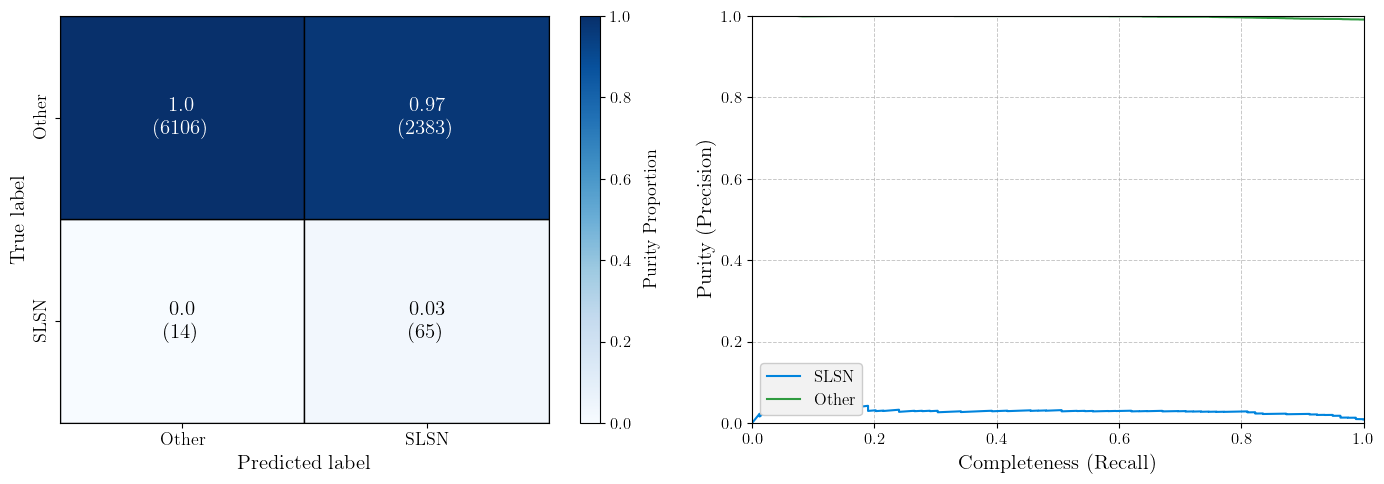

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)

# Choose a colormapclass_weight
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)

try:
    y_tests = np.concatenate(y_tests)
    y_proba = np.concatenate(y_proba)
except:
    print('Didn\'t concat')

try:
    y_tests_sed_only = np.concatenate(y_tests_sed_only)
    y_proba_sed_only = np.concatenate(y_proba_sed_only)
except:
    print('Didn\'t concat')

# Calculate precision and recall
sed_precision, sed_recall, thresholds = precision_recall_curve(y_tests, y_proba[:, 1])
# sed_precision_sed_only, sed_recall_sed_only, thresholds_sed_only = precision_recall_curve(y_tests_sed_only, y_proba_sed_only)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
sed_precision_0, sed_recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba[:, 1], pos_label=0)
# sed_precision_0_sed_only, sed_recall_0_sed_only, thresholds_0_sed_only = precision_recall_curve(y_tests_sed_only, 1 - y_proba_sed_only, pos_label=0)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Split each cell diagonally
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color1, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.5, i + 0.5, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "SLSN"])
ax1.set_yticklabels(["SLSN", "Other"], rotation=90, va='center', ha='right')
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)


# HOST-PROP CLASSIFICATIONS
# Ia
ax2.plot(sed_recall, sed_precision, label='SLSN', color='#0084DD')
naive_model = len(y_test[y_test == 1]) / len(y_test)
# Non-Ia
ax2.plot(sed_recall_0, sed_precision_0, label='Other', color='#2F9B40')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
# SED ONLY CLASSIFICATIONS
# line1 = ax2.plot(sed_recall_sed_only, sed_precision_sed_only, label=r'$grizy$-Based Ia', color='#0084DD', zorder=-1, linestyle='-')
# line1[0].set_dashes([5, 4])  # Increase the spacing between dashes
# Non-Ia
# line2 = ax2.plot(sed_recall_0_sed_only, sed_precision_0_sed_only, label=r'$grizy$-Based CC', color='#2F9B40', zorder=-1, linestyle='--')
# line2[0].set_dashes([5, 4])  # Increase the spacing between dashes

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
ax2.legend(fancybox=True, loc='lower left', framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.show()

###### 2-step Classifier

In [50]:
class TwoStepClassifier():

    def __init__(self, random_state: int = 22, ia_thresh: float = 0.5, cc_class_weights: Union[dict, str] = 'balanced') -> None:
        """
        Initialize a two step classifier consisting of a RF that classifies into Ia vs. CC, and then
        classify the CC into Ib/c, II (P/L), IIn, SLSN. ia_thesh is the minimum probability of being a Ia to call
        something a Ia.
        """
        # Useful attributes
        self.ia_thresh = ia_thresh
        self.random_state = random_state
        self._trained = False

        # Classifiers
        self.base_classifier = RandomForestClassifier(n_estimators=1000, random_state=self.random_state)
        self.cc_classifier = RandomForestClassifier(n_estimators=1000, random_state=self.random_state, class_weight=cc_class_weights)


    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit our models to given data.
        Parameters:
            X: The predictor values for each object.
            y: Array  of the classes of each SN. We will treat 0 as the SN class label.
        """
        # Train the Ia v. CC classifier
        y_Ia_v_rest = (y != 0).astype(int)  # np.array with 0=Ia, I=Other
        self.base_classifier.fit(X, y_Ia_v_rest)

        # Train the non-Ia model
        non_ia_mask = (y != 0)
        self.cc_classifier.fit(X[non_ia_mask], y[non_ia_mask])
        
        self._trained = True


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the classes of the Xs.
        Parameters:
            X: The predictors values of each object.
        Returns:
            1. Predictions of the classes for each object.
        """
        if self._trained is False:
            raise RuntimeError("You must train your TwoStepClassifier model before you predict with it!")

        # Predict Ia v. CC probability
        preds = np.zeros(X.shape[0])
        ia_preds_proba = self.base_classifier.predict_proba(X)[:, 0]
        cc_mask = (ia_preds_proba < self.ia_thresh)
        if np.sum(cc_mask) > 0:
            cc_preds_proba = self.cc_classifier.predict_proba(X[cc_mask])
            preds[cc_mask] = np.argmax(cc_preds_proba, axis=1) + 1

        return preds

        # # Predict Ia v. CC, then predict the CC subclasses
        # preds = self.base_classifier.predict(X)
        # CC_mask = preds != 0
        # preds[CC_mask] = self.cc_classifier.predict(X[CC_mask])

        # return preds

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the probabilities that each of the Xs are a given class.
        Parameters:
            X: The predictors values of each object.
        Returns:
            1. Predictions of the probabilities of the classes for each object.
        """
        if self._trained is False:
            raise RuntimeError("You must train your TwoStepClassifier model before you predict with it!")

        # Predict probas for Ia v. CC, then for the CC subclasses
        y_proba_ia = self.base_classifier.predict_proba(X)
        y_proba_cc = self.cc_classifier.predict_proba(X)
        y_proba = np.hstack([np.atleast_2d(y_proba_ia[:, 0]).reshape(-1, 1), y_proba_ia[:, 1].reshape(-1, 1) * y_proba_cc])

        return y_proba

###### Grid search with the 2 step classifier

In [48]:
weight_grid = ['balanced']
w_vals = np.logspace(start=0, stop=3, base=2, num=4)
print(w_vals)
for v1 in w_vals:
    for v2 in w_vals:
        for v3 in w_vals:
            for v4 in w_vals:
                weight_grid.append({1: v1,
                                    2: v2,
                                    3: v3,
                                    4: v4})
weight_grid

[1. 2. 4. 8.]


['balanced',
 {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0},
 {1: 1.0, 2: 1.0, 3: 1.0, 4: 2.0},
 {1: 1.0, 2: 1.0, 3: 1.0, 4: 4.0},
 {1: 1.0, 2: 1.0, 3: 1.0, 4: 8.0},
 {1: 1.0, 2: 1.0, 3: 2.0, 4: 1.0},
 {1: 1.0, 2: 1.0, 3: 2.0, 4: 2.0},
 {1: 1.0, 2: 1.0, 3: 2.0, 4: 4.0},
 {1: 1.0, 2: 1.0, 3: 2.0, 4: 8.0},
 {1: 1.0, 2: 1.0, 3: 4.0, 4: 1.0},
 {1: 1.0, 2: 1.0, 3: 4.0, 4: 2.0},
 {1: 1.0, 2: 1.0, 3: 4.0, 4: 4.0},
 {1: 1.0, 2: 1.0, 3: 4.0, 4: 8.0},
 {1: 1.0, 2: 1.0, 3: 8.0, 4: 1.0},
 {1: 1.0, 2: 1.0, 3: 8.0, 4: 2.0},
 {1: 1.0, 2: 1.0, 3: 8.0, 4: 4.0},
 {1: 1.0, 2: 1.0, 3: 8.0, 4: 8.0},
 {1: 1.0, 2: 2.0, 3: 1.0, 4: 1.0},
 {1: 1.0, 2: 2.0, 3: 1.0, 4: 2.0},
 {1: 1.0, 2: 2.0, 3: 1.0, 4: 4.0},
 {1: 1.0, 2: 2.0, 3: 1.0, 4: 8.0},
 {1: 1.0, 2: 2.0, 3: 2.0, 4: 1.0},
 {1: 1.0, 2: 2.0, 3: 2.0, 4: 2.0},
 {1: 1.0, 2: 2.0, 3: 2.0, 4: 4.0},
 {1: 1.0, 2: 2.0, 3: 2.0, 4: 8.0},
 {1: 1.0, 2: 2.0, 3: 4.0, 4: 1.0},
 {1: 1.0, 2: 2.0, 3: 4.0, 4: 2.0},
 {1: 1.0, 2: 2.0, 3: 4.0, 4: 4.0},
 {1: 1.0, 2: 2.0, 3: 4.0, 4: 8.0},
 {1: 1.

In [50]:
with open('/Users/adamboesky/Research/ay98/clean_data/rf_cv_data.pkl', 'wb') as f:
    pickle.dump((sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy(), panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()), f)

In [51]:
# Grid search on the Ia threshold
thresh_grid = np.arange(0.1, 1.0, 0.1)
weight_grid = np.logspace(start=0, stop=6, base=2, num=7)
grid_len = len(thresh_grid) * len(weight_grid)

# Arrays to put performance in
mean_purities = []
threshes_log = []
weights_log = []

# grid search
ctr = 0
for weights in weight_grid:
    for thresh in thresh_grid:
        # K fold confusion matrix
        kf = StratifiedKFold(n_splits=5, random_state=22, shuffle=True)
        two_step_classifier = TwoStepClassifier(ia_thresh=thresh)

        # Initialize a matrix to hold the summed confusion matrix
        cumulative_cm = np.array([[0 for _ in range(5)] for _ in range(5)])

        # Initialize lists of the scores for the purity vs. completeness graphs
        y_tests = []
        y_proba = []
        f1_scores = []

        # X and y set
        preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
        pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
        pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

        # Iterate over each fold
        for train_index, test_index in kf.split(pstar_X, pstar_y):

            ### NN-INFERRED DATA ###
            # Split the data into training and test sets for the current fold
            X_train, X_test = pstar_X[train_index], pstar_X[test_index]
            y_train, y_test = pstar_y[train_index], pstar_y[test_index]

            # Do SMOTE resampling
            # X_train, y_train = smote.fit_resample(X_train, y_train)

            # Fit and get confusion matrix
            # Non-balanced weights
            two_step_classifier.fit(X_train, y_train)
            y_pred = two_step_classifier.predict(X_test)
            cumulative_cm += confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])

        # Store the mean purity of CC classes
        cm_col_norms = np.sum(cumulative_cm, axis=0)
        cm_norm = cumulative_cm / cm_col_norms
        cm_norm[np.isnan(cm_norm)] = 0

        # Log
        mean_purities.append(np.mean(np.diag(cm_norm)[1:]))
        threshes_log.append(thresh)
        weights_log.append(weights)
        ctr += 1
        print(f'{ctr} / {grid_len}')

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/3817002247.py:51: RuntimeWarning: invalid value encountered in divide
  cm_norm = cumulative_cm / cm_col_norms


1 / 63


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/3817002247.py:51: RuntimeWarning: invalid value encountered in divide
  cm_norm = cumulative_cm / cm_col_norms


2 / 63


KeyboardInterrupt: 

In [206]:
max_thresh = max(mean_purities, key=mean_purities.get)
max_value = mean_purities[max_thresh]

print(f'Max mean purity: {max_value}, Key: {max_thresh}')

Max mean purity: 0.3354166666666667, Key: 0.2


In [83]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)
# two_step_classifier = TwoStepClassifier(ia_thresh=max_thresh)
two_step_classifier = TwoStepClassifier(random_state=22, ia_thresh=0.2, cc_class_weights={1: 1.0, 2: 8.0, 3: 8.0, 4: 1.0})

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0 for _ in range(5)] for _ in range(5)])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
f1_scores = []

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()

# Iterate over each fold
for train_index, test_index in kf.split(pstar_X, pstar_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = pstar_X[train_index], pstar_X[test_index]
    y_train, y_test = pstar_y[train_index], pstar_y[test_index]

    # Do SMOTE resampling
    # X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    two_step_classifier.fit(X_train, y_train)
    y_pred = two_step_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])

    # Get the info for the purity vs. completeness curve
    y_pred_proba = two_step_classifier.predict_proba(X_test)
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)

    # Get the f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')  # Adjust the 'average' parameter as needed
    f1_scores.append(f1)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/3947833268.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13139/3947833268.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


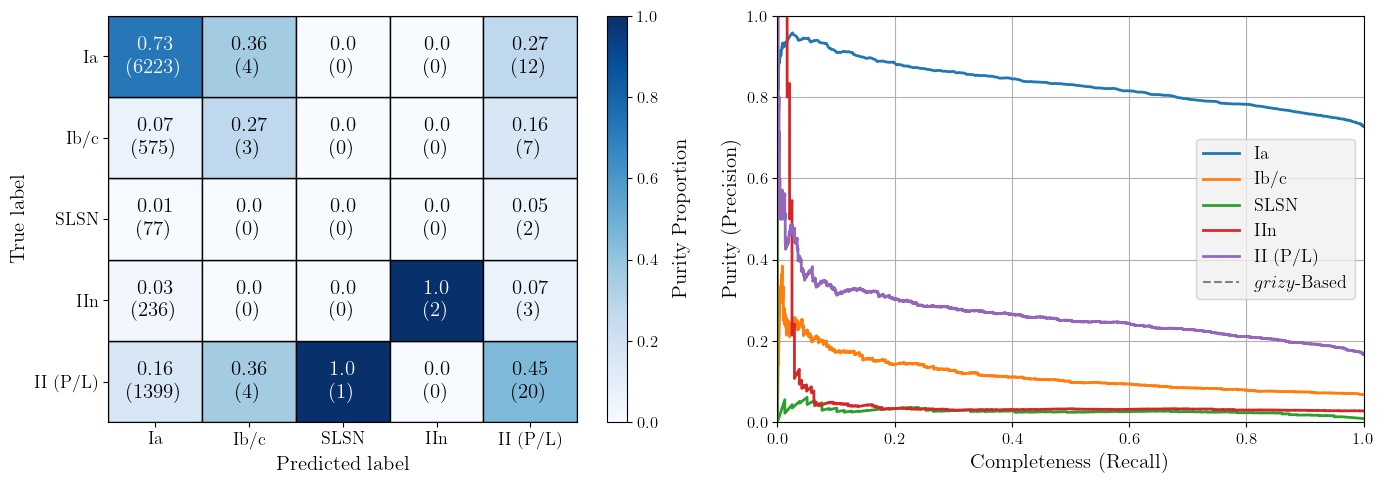

In [84]:
# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(cumulative_cm)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Concatenate the arrays in y_tests and y_proba
# if y_tests.ndim != 1:
y_tests_concatenated = np.concatenate(y_tests)
y_proba_concatenated = np.concatenate(y_proba, axis=0)
# if y_tests_sed_only.ndim != 1:
# y_tests_sed_only_concatenated = np.concatenate(y_tests_sed_only)
# y_proba_sed_only_concatenated = np.concatenate(y_proba_sed_only, axis=0)

# Ensure y_proba_concatenated is a 2D array
if y_proba_concatenated.ndim == 1:
    y_proba_concatenated = y_proba_concatenated.reshape(-1, 1)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (y_tests_concatenated == i)
    proba_binary = y_proba_concatenated[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

    # # Treat class i as the positive class
    # true_binary = (y_tests_sed_only_concatenated == i)
    # proba_binary = y_proba_sed_only_concatenated[:, i]

    # precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    # line = ax2.plot(recall, precision, color=color, lw=2)
    # line[0].set_dashes([5, 4])  # Increase the spacing between dashes

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
grizy = mlines.Line2D([], [], color='gray', linestyle='--', label=r'$grizy$-Based')
handles, labels = ax2.get_legend_handles_labels()
handles.append(grizy)
ax2.legend(handles=handles, fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()

## YSE Test Set and Balancing

### Read in Data

In [36]:
yse_sne_orig = pd.read_csv(os.path.join('/Users/adamboesky/Research/ay98/clean_data/parsnip_results_for_ysedr1_table_A1_full_for_online.csv'))
# yse_sne_orig[pd.isnull(yse_sne_orig['Spec. Class'])].to_csv('your_filename.csv', na_rep='nan', index=False)

In [37]:
# Get the preprocessed YSE data
yse_df = ascii.read("/Users/adamboesky/Research/ay98/clean_data/yse_hosts.ecsv", delimiter=' ', format='ecsv')
yse_df = propocess_tab(yse_df)
yse_df

Dropped 24/406 rows due to missingness. Now have 382


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,rKronMagErr_3pi,iKronMagErr_3pi,zKronMagErr_3pi,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec
0,1.669913e+17,133.895464,49.160540,1.0,20.0062,19.9385,19.5204,19.5922,19.7011,0.022047,0.022569,0.017368,0.038479,0.075460,0.002917,133.897475,49.160259,SNII,0.135,4.840800
1,9.751147e+16,147.177177,-8.733965,1.0,16.3980,15.7183,15.3767,15.1736,15.0371,0.001966,0.001280,0.001190,0.001611,0.004119,0.058655,147.176208,-8.734392,SNIa-norm,0.053,3.775146
2,1.341218e+17,177.776175,21.767210,1.0,17.6355,16.9783,16.6460,16.4204,16.3375,0.005596,0.004884,0.004178,0.005598,0.010297,0.067542,177.772596,21.767258,SNIa-norm,0.059,11.966282
3,1.071805e+17,51.169888,-0.681455,1.0,15.3756,14.7510,14.4013,14.1579,13.9560,0.001651,0.001218,0.001010,0.001473,0.002739,0.171316,51.172538,-0.681409,SNII,0.022,9.541133
4,1.336019e+17,192.567619,21.337266,1.0,17.8554,17.6340,17.3751,17.3708,17.3009,0.004552,0.005694,0.004355,0.009003,0.016486,0.003750,192.567042,21.337646,SNIIn,0.086,2.370583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,9.114022e+16,22.064911,-14.049546,1.0,18.0565,17.3057,16.8992,16.6476,16.4545,0.005967,0.003391,0.002819,0.004350,0.008465,0.001750,22.065450,-14.051486,SNIa-norm,0.104,7.235150
378,1.221932e+17,322.906454,11.831660,1.0,14.7039,13.9191,13.5128,13.2656,13.0388,0.001149,0.000554,0.000442,0.000779,0.001450,0.160024,322.906997,11.832946,SNIa-norm,0.025,5.008624
379,1.197132e+17,317.348329,9.761803,1.0,16.9430,16.4661,16.0112,15.9251,15.7482,0.004014,0.003771,0.002223,0.003747,0.007402,0.020833,317.348935,9.760885,SNIbn,0.080,3.943161
380,1.587214e+17,140.211687,42.272428,1.0,16.4714,16.0417,15.8206,15.6633,15.5445,0.002940,0.001529,0.001335,0.003494,0.008233,0.045768,140.211901,42.272211,SNIa-norm,0.033,0.968020


In [38]:
# Add columns that denote the SN classes
yse_df = add_sn_class_cols(yse_df)
yse_df

The data are 67.28% type ia with n = 257
The data are 9.42% type ib/c with n = 36
The data are 0.26% type slsn with n = 1
The data are 2.88% type iin with n = 11
The data are 20.16% type ii (p/l) with n = 77


,objID_3pi,raStack_3pi,decStack_3pi,primaryDetection_3pi,gKronMag_3pi,rKronMag_3pi,iKronMag_3pi,zKronMag_3pi,yKronMag_3pi,gKronMagErr_3pi,...,yKronMagErr_3pi,ps_score_3pi,SN_ra,SN_dec,sn_class,sn_redshift,angular_separation_arcsec,sn_class_binary,sn_class_tertiary,sn_class_cat
0,1.669913e+17,133.895464,49.160540,1.0,20.0062,19.9385,19.5204,19.5922,19.7011,0.022047,...,0.075460,0.002917,133.897475,49.160259,SNII,0.135,4.840800,0,1,4
1,9.751147e+16,147.177177,-8.733965,1.0,16.3980,15.7183,15.3767,15.1736,15.0371,0.001966,...,0.004119,0.058655,147.176208,-8.734392,SNIa-norm,0.053,3.775146,1,0,0
2,1.341218e+17,177.776175,21.767210,1.0,17.6355,16.9783,16.6460,16.4204,16.3375,0.005596,...,0.010297,0.067542,177.772596,21.767258,SNIa-norm,0.059,11.966282,1,0,0
3,1.071805e+17,51.169888,-0.681455,1.0,15.3756,14.7510,14.4013,14.1579,13.9560,0.001651,...,0.002739,0.171316,51.172538,-0.681409,SNII,0.022,9.541133,0,1,4
4,1.336019e+17,192.567619,21.337266,1.0,17.8554,17.6340,17.3751,17.3708,17.3009,0.004552,...,0.016486,0.003750,192.567042,21.337646,SNIIn,0.086,2.370583,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,9.114022e+16,22.064911,-14.049546,1.0,18.0565,17.3057,16.8992,16.6476,16.4545,0.005967,...,0.008465,0.001750,22.065450,-14.051486,SNIa-norm,0.104,7.235150,1,0,0
378,1.221932e+17,322.906454,11.831660,1.0,14.7039,13.9191,13.5128,13.2656,13.0388,0.001149,...,0.001450,0.160024,322.906997,11.832946,SNIa-norm,0.025,5.008624,1,0,0
379,1.197132e+17,317.348329,9.761803,1.0,16.9430,16.4661,16.0112,15.9251,15.7482,0.004014,...,0.007402,0.020833,317.348935,9.760885,SNIbn,0.080,3.943161,0,2,1
380,1.587214e+17,140.211687,42.272428,1.0,16.4714,16.0417,15.8206,15.6633,15.5445,0.002940,...,0.008233,0.045768,140.211901,42.272211,SNIa-norm,0.033,0.968020,1,0,0


In [39]:
def angular_separation(ra1, dec1, ra2, dec2):
    """
    Calculate the angular separation between two points in the sky.
    ra1, dec1: Right ascension and declination of the first point in degrees.
    ra2, dec2: Right ascension and declination of the second point in degrees.
    """
    # Convert to radians
    ra1, dec1, ra2, dec2 = map(np.radians, [ra1, dec1, ra2, dec2])
    
    # Calculate angular separation
    delta_ra = ra2 - ra1
    return np.degrees(np.arccos(np.sin(dec1) * np.sin(dec2) + np.cos(dec1) * np.cos(dec2) * np.cos(delta_ra)))

# Assuming yse_sne and panstarr_df are your dataframes and have 'ra' and 'dec' columns
not_in_test_mask = []
for index, row in panstarr_df.iterrows():
    # Calculate angular separations to all yse_sne points
    separations = angular_separation(row['SN_ra'], row['SN_dec'], yse_df['SN_ra'], yse_df['SN_dec'])
    
    # Check if all separations are greater than 1 arcsecond
    not_in_test_mask.append(not np.any(separations < 1/3600))
not_in_test_mask = np.array(not_in_test_mask)

# Print info
print(f'There are {np.sum(~not_in_test_mask)} sne in both the panstarrs and YSE datasets. Dropping from panstarrs...')
panstarr_df_train = panstarr_df[not_in_test_mask]
print(f'Dropped from {len(panstarr_df)} to {len(panstarr_df_train)} rows.')
for idx, snt in enumerate(('ia', 'ib/c', 'slsn', 'iin', 'ii (p/l)')):
    print(f'The training data are {np.round(len(panstarr_df_train[panstarr_df_train["sn_class_cat"] == idx]) / len(panstarr_df_train) * 100, 2)}% type {snt} with n = {len(panstarr_df_train[panstarr_df_train["sn_class_cat"] == idx])}')

There are 341 sne in both the panstarrs and YSE datasets. Dropping from panstarrs...
Dropped from 9407 to 9066 rows.
The training data are 68.27% type ia with n = 6189
The training data are 6.89% type ib/c with n = 625
The training data are 0.87% type slsn with n = 79
The training data are 2.75% type iin with n = 249
The training data are 16.48% type ii (p/l) with n = 1494


### Domain Transfer for YSE

In [40]:
yse_photo_mag = yse_df[['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi']].to_numpy()
yse_photo_err_mag = yse_df[['gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi']].to_numpy()

In [41]:
ab_magerr_to_ferr = lambda sigma_m, f: np.abs(f * np.log(10) * (sigma_m / 2.5))  # transformation on the error of a magnitude turned into flux

# Convert the data from mags to flux
yse_photo = ab_mag_to_flux(yse_photo_mag)
yse_photo_err = ab_magerr_to_ferr(yse_photo_err_mag, yse_photo)

In [42]:
# Impute missing data
yse_photo_imputed = np.isnan(yse_photo)  # Indicator of what is imputed or not
imputer = KNNImputer(n_neighbors=5)
yse_photo = imputer.fit_transform(yse_photo)
yse_photo_err = imputer.fit_transform(yse_photo_err)

In [43]:
# Apply log transform to the SEDs
yse_photo_err = np.abs(yse_photo_err / (yse_photo * np.log(10)))
yse_photo = np.log10(yse_photo)

# Normalize data
yse_photo_norm, yse_photo_mean, yse_photo_std, yse_photo_err_norm = normalize_arr(yse_photo, errors=yse_photo_err, mean=photo_mean[:5], std=photo_std[:5])

In [44]:
# Predict SEDs
yse_sed_preds = sed_model(torch.from_numpy(yse_photo_norm)).detach().numpy()
yse_full_pred = np.hstack((yse_photo_norm, yse_sed_preds))  # note that this is still scaled to be input into the host prop NN

### Predict Host Properties

In [45]:
# Predict the properties
yse_props_unnorm = model(torch.from_numpy(yse_full_pred)).detach().numpy()

# Scale the properties by the Zou mean and std
yse_props = yse_props_unnorm * cat_std + cat_mean

In [46]:
# Make a df
yse_sne_df = pd.DataFrame(np.hstack((yse_df[['sn_class_cat', 'angular_separation_arcsec']], yse_props)), columns=[r'Supernova Type', r'$\log(\rm{Separation})$ [$^{\prime\prime}$]', r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$]', r'Redshift'])
yse_sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = pd.to_numeric(yse_sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'], errors='coerce')
yse_sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'] = np.log10(yse_sne_df[r'$\log(\rm{Separation})$ [$^{\prime\prime}$]'])

# Filter for everything predicted to be z \in [0, 1]
yse_z_mask = (yse_sne_df['Redshift'] < 1) & (yse_sne_df['Redshift'] > 0)
print(np.sum(~yse_z_mask), len(yse_z_mask))

# Filter for within 4 stdevs of training data
yse_within_training_mask = np.all((yse_props_unnorm < 4) & (yse_props_unnorm > -4), axis=1)
print(np.sum(~yse_within_training_mask), len(yse_within_training_mask))

21 382
0 382


### Classify

In [47]:
def get_downsample_mask(classes: np.array, pct: float, class_name: int):
    """
    Returns a mask for randomly selected 50% of the rows where the specified column's value is 0.
    """
    # Find indices of rows where the value in the specified column is 0
    indices_of_zero = np.where(classes == class_name)[0]

    # Randomly select the given percent of these indices
    random_selection = np.random.choice(indices_of_zero, size=int(len(indices_of_zero) * pct), replace=False)

    # Initialize mask to False for all rows and set mask to True for randomly selected indices
    mask = np.zeros(classes.shape[0], dtype=bool)
    mask[random_selection] = True

    return ~mask

In [51]:
# K fold confusion matrix
smote = SMOTE(random_state=22)
# rf_classifier_multi =  RandomForestClassifier(n_estimators=1000, random_state=22, class_weight='balanced')
custom_classifier = TwoStepClassifier(random_state=22, ia_thresh=0.2, cc_class_weights={1: 1.0, 2: 8.0, 3: 8.0, 4: 1.0})

# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
X_train = sne_df[preds][within_training_mask & z_mask & good_class_mask & not_in_test_mask].to_numpy()
y_train = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask & not_in_test_mask].to_numpy()
X_test = yse_sne_df[preds][yse_within_training_mask & yse_z_mask].to_numpy()
y_test = yse_df['sn_class_cat'][yse_within_training_mask & yse_z_mask].to_numpy()

# Rebalancing
# downsample_mask = get_downsample_mask(y_train, 0.4, 0)
# X_train = X_train[downsample_mask]
# y_train = y_train[downsample_mask]
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Train
custom_classifier.fit(X_train, y_train)

# Predict
y_pred = custom_classifier.predict(X_test)
yse_cm = confusion_matrix(y_test, y_pred, labels=[i for i in range(5)])
yse_y_pred_proba = custom_classifier.predict_proba(X_test)
pd.DataFrame(y_train).value_counts()

0    6016
4    1363
1     557
3     232
2      79
Name: count, dtype: int64

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9474/591764530.py:9: RuntimeWarning: invalid value encountered in divide
  cm1_norm = cm1 / cm1_col_norms
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9474/591764530.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_9474/591764530.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


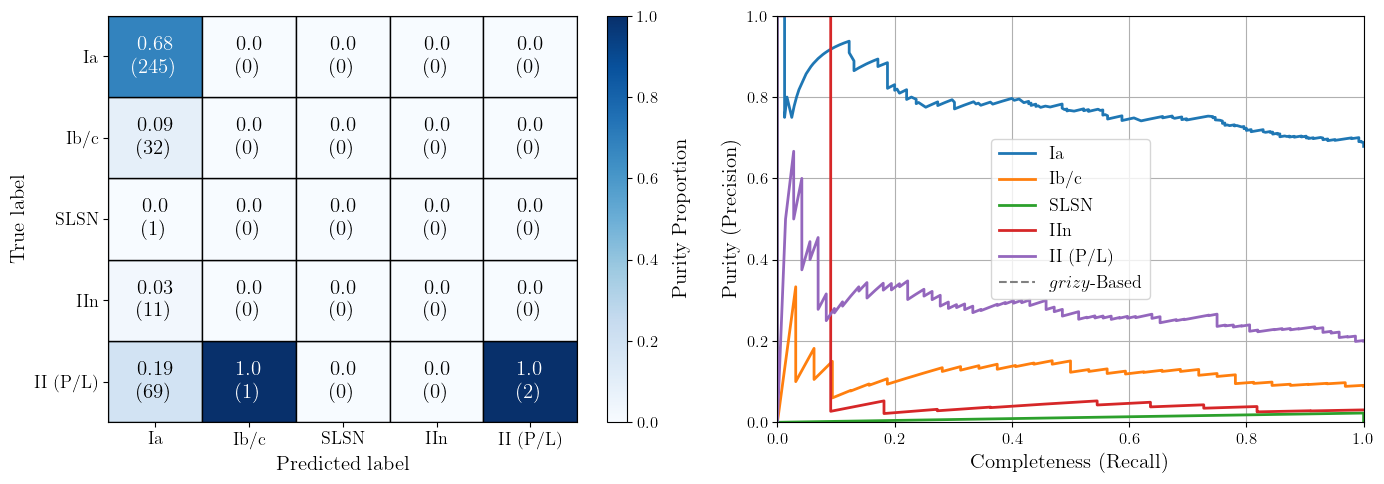

In [53]:
# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(yse_cm)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (y_test == i)
    proba_binary = yse_y_pred_proba[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
grizy = mlines.Line2D([], [], color='gray', linestyle='--', label=r'$grizy$-Based')
handles, labels = ax2.get_legend_handles_labels()
handles.append(grizy)
ax2.legend(handles=handles, fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()

### Try the lightgbm classifier

In [52]:
with open('/Users/adamboesky/Research/ay98/clean_data/gbm_data.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

In [57]:
import lightgbm as lgb

lgb_train_data = lgb.Dataset(X_train, label=y_train)
params = {'objective': 'multiclass', 'num_classes': 5, 'seed': 22}

OSError: dlopen(/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <1252A0DB-7E0B-3917-A499-47AE7C0E2058> /Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [58]:
bst = lgb.train(params=params, train_set=lgb_train_data)

: 

# Do this stuff later :(
    Kinda waiting on Sebastian/Villar input, don't understand why we don't just use TNS

In [246]:
################### FOR LATER WHEN CROSS CHECKING THE YSE ####################
tns_sne = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/TNS_sebastian.csv')
tns_sne

,objid,name_prefix,name,ra,declination,redshift,typeid,type,reporting_groupid,reporting_group,...,source_group,discoverydate,discoverymag,discmagfilter,filter,reporters,time_received,internal_names,creationdate,lastmodified
0,144554,AT,2024agb,208.775842,20.484827,NaN,NaN,NaN,74.0,ALeRCE,...,ZTF,2024-01-15 12:28:30.996,18.6162,110.0,g,"A. Munoz-Arancibia, F.E. Bauer, F. Forster, G....",2024-01-15 23:21:17,ZTF19acvevgj,2024-01-15 23:21:25,2024-01-15 23:21:25
1,144553,AT,2024aga,166.214166,-24.620634,NaN,NaN,NaN,74.0,ALeRCE,...,ZTF,2024-01-15 11:33:23.000,20.0899,111.0,r,"A. Munoz-Arancibia, F.E. Bauer, F. Forster, G....",2024-01-15 23:21:17,ZTF23aadpohs,2024-01-15 23:21:25,2024-01-15 23:21:25
2,144552,AT,2024afz,170.642371,18.687674,NaN,NaN,NaN,74.0,ALeRCE,...,ZTF,2024-01-13 10:59:11.000,20.5269,110.0,g,"A. Munoz-Arancibia, F.E. Bauer, F. Forster, G....",2024-01-15 23:21:17,ZTF24aabvgpr,2024-01-15 23:21:24,2024-01-15 23:21:24
3,144551,AT,2024afy,176.352770,-5.089675,NaN,NaN,NaN,74.0,ALeRCE,...,ZTF,2024-01-13 11:33:32.003,19.7632,110.0,g,"A. Munoz-Arancibia, F.E. Bauer, F. Forster, G....",2024-01-15 23:21:17,ZTF24aabvpvi,2024-01-15 23:21:23,2024-01-15 23:21:23
4,144550,AT,2024afx,144.033801,60.300372,NaN,NaN,NaN,74.0,ALeRCE,...,ZTF,2024-01-13 07:07:12.003,20.3214,110.0,g,"A. Munoz-Arancibia, F.E. Bauer, F. Forster, G....",2024-01-15 23:21:17,ZTF24aabxnem,2024-01-15 23:21:22,2024-01-15 23:21:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131636,6336,SN,2013hj,138.026210,-15.429440,NaN,10.0,SN II,NaN,NaN,...,NaN,2013-12-12 00:00:00.000,14.0000,NaN,NaN,"Antezana, Pignata et al.",2021-02-20 10:34:14,NaN,2015-12-31 10:59:55,2015-12-31 10:59:55
131637,6309,SN,2013gj,40.291670,-21.024780,NaN,10.0,SN II,NaN,NaN,...,NaN,2013-11-10 00:00:00.000,17.5000,NaN,NaN,A.J. Drake et al.,2021-02-17 11:24:00,NaN,2015-12-31 10:59:55,2015-12-31 10:59:55
131638,6201,SN,2013cj,256.220630,12.919560,NaN,13.0,SN IIn,NaN,NaN,...,NaN,2013-05-09 00:00:00.000,18.1000,NaN,NaN,"Jin, Z.; Gao, X.; Xingming Sky Survey",2021-03-04 11:18:11,NaN,2015-12-31 10:59:55,2015-12-31 10:59:55
131639,6196,SN,2013ce,173.961670,34.284080,NaN,11.0,SN IIP,NaN,NaN,...,NaN,2013-05-01 00:00:00.000,17.3000,NaN,NaN,iPTF,2017-09-08 16:23:17,iPTF13ce,2015-12-31 10:59:55,2015-12-31 10:59:55


In [248]:
tns_sne.columns, tns_sne['type']

(Index(['objid', 'name_prefix', 'name', 'ra', 'declination', 'redshift',
        'typeid', 'type', 'reporting_groupid', 'reporting_group',
        'source_groupid', 'source_group', 'discoverydate', 'discoverymag',
        'discmagfilter', 'filter', 'reporters', 'time_received',
        'internal_names', 'creationdate', 'lastmodified'],
       dtype='object'),
 0            NaN
 1            NaN
 2            NaN
 3            NaN
 4            NaN
            ...  
 131636     SN II
 131637     SN II
 131638    SN IIn
 131639    SN IIP
 131640    SN IIP
 Name: type, Length: 131641, dtype: object)

In [253]:
tns_sne['type'][0], type(tns_sne['type'][0]), pd.isnull(tns_sne['type'][0])

(nan, float, True)

In [255]:
# Add TNS classes to the data
in_tns_mask = []
in_tns_clases = []
for index, row in tns_sne.iterrows():
    # Calculate angular separations to all yse_sne points
    separations = angular_separation(row['ra'], row['declination'], yse_df['SN_ra'], yse_df['SN_dec'])

    # Check if all separations are greater than 1 arcsecond
    if not pd.isnull(row['type']):
        in_tns_clases.append(row['type'])
        in_tns_mask.append(not np.any(separations < 1/3600))
    else:
        in_tns_mask.append(False)
in_tns_mask = np.array(in_tns_mask)

# Print info
print(f'There are {np.sum(in_tns_mask)} sne in YSE that are in TNS.')

There are 15281 sne in YSE that are classified in TNS.


In [259]:
tns_sne['type'][in_tns_mask]

108              SN Ia
113              SN Ia
114              SN II
116              Other
117              SN Ia
120              SN Ib
205              SN Ia
207              SN Ic
208              SN Ia
209           SN Ic-BL
210             SN IIb
212              SN Ia
213              SN Ia
214              SN Ia
215    SN Ia-91bg-like
259              SN II
261              SN Ia
262              SN Ia
263              SN Ia
264              SN II
265             SN IIP
266              SN Ia
267              SN Ia
268              SN Ia
269              SN II
293                FRB
296              SN Ia
299              SN Ia
300              SN Ia
301             SN IIP
323              SN Ia
341              SN II
344              SN Ia
346              SN Ia
349              SN II
359             SLSN-I
401              SN Ia
403              SN Ia
404              SN Ia
406              SN Ia
Name: type, dtype: object

##### Using hxe-tda

In [310]:
sys.path.insert(0, '../hxe-for-tda/hxetda/')
import hxetda
import networkx as nx
import importlib
importlib.reload(hxetda)

<module 'hxetda' from '/Users/adamboesky/Research/ay98/Weird_Galaxies/../hxe-for-tda/hxetda/hxetda.py'>

In [247]:
# X and y set
preds = ['$\\log(\\rm{Separation})$ [$^{\\prime\\prime}$]', '$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\rm{yr}^{-1}$]', 'Redshift']
pstar_X = sne_df[preds][within_training_mask & z_mask & good_class_mask].to_numpy()
pstar_y = panstarr_df['sn_class_cat'][within_training_mask & z_mask & good_class_mask].to_numpy()
label_dict = {0.0: 'Ia', 1.0: 'Ib/c', 2.0: 'SLSN', 3.0: 'IIn', 4.0: 'II (P/L)'}
pstar_y_labs = np.array([label_dict[y] for y in pstar_y])

# Regularize the predictors
scaler = StandardScaler()
pstar_X = scaler.fit_transform(pstar_X)

['SN' 'Ia' 'Ib/c' 'SLSN' 'IIn' 'II (P/L)' 'CC' 'Hr' 'Hp']


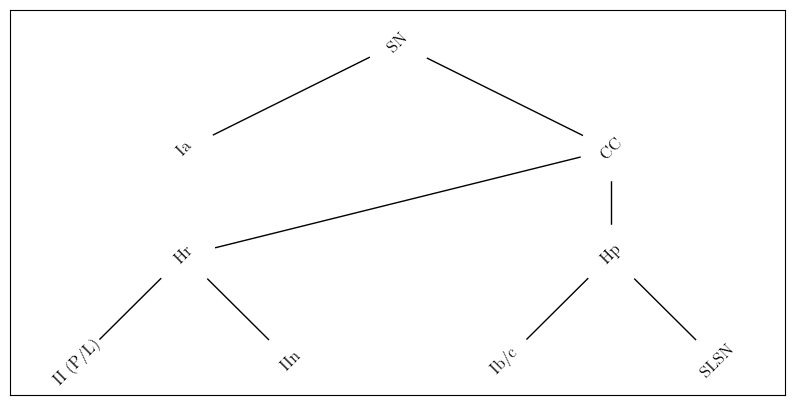

In [244]:
# Create a graph
G=nx.DiGraph()

G.add_edge('SN', 'Ia')
G.add_edge('SN', 'CC')

G.add_edge('CC', 'Hr')
G.add_edge('Hr', 'II (P/L)')
G.add_edge('Hr', 'IIn')

G.add_edge('CC', 'Hp')
G.add_edge('Hp', 'Ib/c')
G.add_edge('Hp', 'SLSN')

pos = hxetda.hierarchy_pos(G, 'SN')
vertices = np.array(list(label_dict.values()) + ['CC', 'Hr', 'Hp'], dtype=str)
vertices = np.insert(vertices, 0, 'SN')
print(vertices)

fig = plt.figure(1, figsize=(10, 5))

nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)
for _, t in text.items():
    t.set_rotation(45) 

plt.show()

In [248]:
# Get paths
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'SN')

# Some pre-processing for the class weights
class_weight_dict = hxetda.calc_class_weights(pstar_y_labs, vertices, paths)
print(class_weight_dict)

{'II (P/L)': array([1.20337079]), 'IIn': array([7.11037344]), 'Ia': array([0.2746594]), 'Ib/c': array([2.92923077]), 'SLSN': array([21.69113924])}


In [249]:
# Label dictionary
labels_y = np.array([label_dict[c] for c in pstar_y])

# Get weights
class_weight_dict = hxetda.calc_class_weights(labels_y, vertices, paths)

In [283]:
# Set up for train test split...
labels_new = [y_dict[x] for x in labels_y]
weights = [class_weight_dict[x] for x in labels_y]
if not isinstance(pstar_X, torch.Tensor):
    pstar_X = torch.from_numpy(pstar_X)
# if not isinstance(labels_new, torch.Tensor):
#     labels_new = torch.from_numpy(labels_new)
X_train, X_test, y_train, y_test, labels_train, labels_test, weights_train, weights_test = train_test_split(pstar_X, labels_new, pstar_y_labs, weights, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

weights_train = torch.tensor(weights_train, dtype=torch.float64)
weights_test = torch.tensor(weights_test, dtype=torch.float64)

print(np.shape(X_train))

torch.Size([6854, 4])


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/74600041.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float64)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/74600041.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float64)


6854


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/311350183.py:29: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/311350183.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)


1 -1.136649747291079 -1.134254185834997
101 -1.1823899769814998 -1.1508587797344896
201 -1.1961000893737366 -1.1534864741067707
301 -1.2004140023955305 -1.1546638059076315
401 -1.202976460652522 -1.1554005034657109
501 -1.203957798354056 -1.15578916145354
601 -1.203793369836976 -1.1560649102657243
701 -1.204189458540264 -1.15632758688976
801 -1.2051792127311827 -1.1566768818777757
901 -1.2061740692289644 -1.1570750598628115


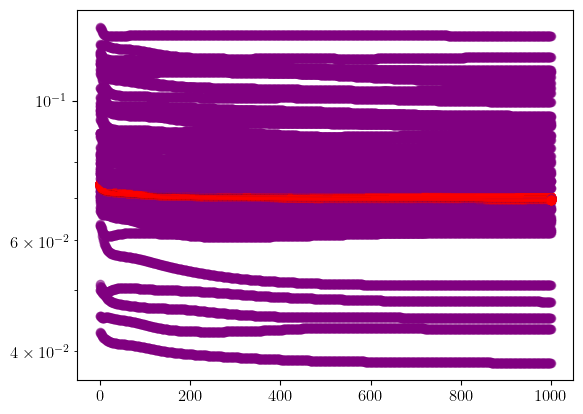

In [333]:
alphas = [2.0]
for alpha, col in zip(alphas, ('purple', 'blue', 'green')):
	model = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(vertices))
	optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
	model.train()
	epoch = 1000
	n_batches = 128
	loss=torch.tensor(0)
	print(len(X_train))
	for epoch in range(epoch):
		if epoch%100==1:
			print(epoch, np.log10(loss.detach().numpy()), np.log10(loss2.detach().numpy()))
		for i in range(int(len(X_train)/n_batches)+1):

			# Local batches and labels
			local_X, local_y, local_weights = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,], weights_train[i*n_batches:(i+1)*n_batches,]
			local_X = local_X.to(torch.float64)  # Ensure local_X is float32
			optimizer.zero_grad()

			# Forward pass
			y_pred = model(local_X)

			# Compute Loss
			loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), local_weights, mask_list, pathlengths, alpha=alpha)

			# Backward pass
			loss.backward()
			optimizer.step()
			plt.plot(epoch,loss.detach().numpy(),'ko', lw=0.1, color=col, alpha=0.5)
			ypred2 = model(X_test)
			loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), weights_test, mask_list, pathlengths, alpha=alpha)
			plt.plot(epoch,loss2.detach().numpy(),'ro', lw=0.1, alpha=0.5)

	#scheduler.step()
	plt.yscale('log')
	plt.show()

In [334]:
model.eval()
y_pred = model(X_test)

In [335]:
leaves = np.array(list(label_dict.values()), dtype=str)
probs_list = np.zeros((len(y_pred), len(leaves)))
for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred, leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]
fiveleaf_labels_test = np.copy(labels_test)

for i,s in enumerate(fiveleaf_labels_test):
    is_Ibc = hxetda.is_parent(s, 'SN Ib/c', vertices, paths)
    if is_Ibc:
        fiveleaf_labels_test[i] = 'SN Ib/c'

gind = np.where(np.in1d(fiveleaf_labels_test,leaves))[0]
cm_hier = confusion_matrix(fiveleaf_labels_test[gind], my_predicted_types[gind], labels=leaves)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/3131542241.py:11: RuntimeWarning: invalid value encountered in divide
  cm1_norm = cm1 / cm1_col_norms
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/3131542241.py:16: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_13837/3131542241.py:42: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


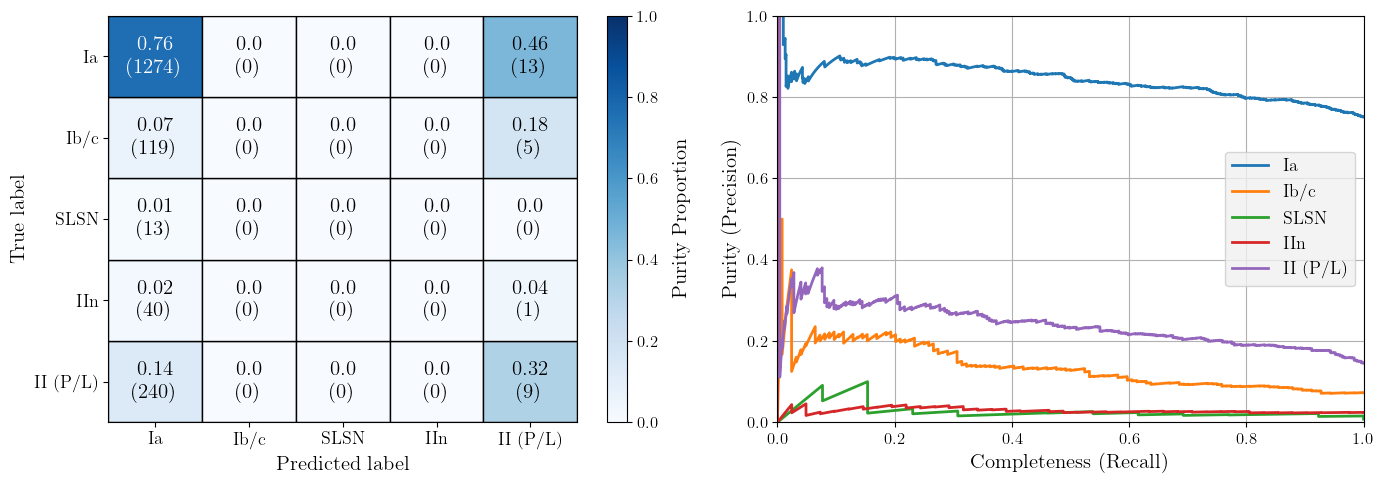

In [336]:
from itertools import cycle

# Assuming cumulative_cm is a 5x5 confusion matrix
# Update the colormap bounds and create a mesh grid for 5 classes
bounds = np.arange(6)
X, Y = np.meshgrid(bounds, bounds)

# Normalize the confusion matrix
cm1 = np.flipud(cm_hier)
cm1_col_norms = np.sum(cm1, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm1_norm = cm1_norm.round(2)
cm1_norm[np.isnan(cm1_norm)] = 0

# Plotting the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cmap = plt.cm.Blues
norm = plt.Normalize(vmin=0, vmax=1)

for (i, j), z in np.ndenumerate(cm1_norm):
    color = cmap(norm(z))
    ax1.fill_between([j, j+1], [i, i], [i+1, i+1], color=color, edgecolor='black')
    text_color = 'white' if z > 0.5 else 'black'
    ax1.text(j + 0.5, i + 0.5, f'{z}\n({cm1[i, j]})', ha='center', va='center', fontsize=15, color=text_color)

# Set the limits and labels for 5 classes
class_labels = ['Ia', 'Ib/c', 'SLSN', 'IIn', 'II (P/L)']  # Replace with actual class names
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xticks(np.arange(0.5, 5.5))
ax1.set_yticks(np.arange(0.5, 5.5))
ax1.set_xticklabels(class_labels)
ax1.set_yticklabels(class_labels[::-1])
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.grid(False)
ax1.set_xlabel('Predicted label', fontsize=15)
ax1.set_ylabel('True label', fontsize=15)

# Colorbar for the confusion matrix
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=15)

# Plotting the precision-recall curves
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(5), colors):

    # Treat class i as the positive class
    true_binary = (labels_test == class_labels[i])
    proba_binary = probs_list[:, i]

    precision, recall, _ = precision_recall_curve(true_binary, proba_binary)
    ax2.plot(recall, precision, color=color, lw=2, label=class_labels[i])

ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.legend(fontsize=13)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.grid(True)

plt.tight_layout()
# plt.savefig('path_to_save_figure.pdf', bbox_inches='tight')
plt.show()